# Use pytorch to predict the enrichment results from Cuperus et al
Supp data downloaded from here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2793752

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load cuperus data

In [4]:
df = pd.read_csv("data/cuperus_random_utrs.csv",index_col=0).reset_index().rename(columns={'index':'id'})
df

id                                                UTR  \
0            0  AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...   
1            1  AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...   
2            2  AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...   
3            3  AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...   
4            4  AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...   
...        ...                                                ...   
489343  489343  TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...   
489344  489344  TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...   
489345  489345  TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...   
489346  489346  TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...   
489347  489347  TTTTTTTTCGGCATTTATGTAAGTGAGCTTGCGAAGACAAGCTACA...   

        growth_rate  t0   t1  
0         -1.237065  14    3  
1          1.288663  14   49  
2         -0.608457  13    6  
3         -1.093964  12    3  
4         -0.048841   7    6  
...             ...  ..  ...  
489343     1.380601  80  295  
489344     0.796187  26   54  
489345     0.731318  10   20  
489346    -0.944929  13    4  
489347    -2.112534   8    0  

[489348 rows x 5 columns]

### Spot check the calculations to make sure I understand where the growth_rate column comes from

Description of data generation:
* First, a pseudocount of 1 was added to each sequence count. 
* Sequence counts in each condition (e.g. input, random library) were then normalized to the total counts in that condition. 
* The enrichment was calculated by log2(selection/input) -> **Error: they appear to have used natural log (np.log) instead of log2**
* Supplementary_files_format_and_content: .csv files. Files include columns with the UTR sequence, the raw counts for the input and following selection (t0 and t1, respectively) and the enrichment score.

In [5]:
df['t0_ps'] = df['t0'] + 1
df['t1_ps'] = df['t1'] + 1

sum_t0 = sum(df['t0_ps'].values)
sum_t1 = sum(df['t1_ps'].values)

df['t0_norm'] = df['t0_ps']/sum_t0
df['t1_norm'] = df['t1_ps']/sum_t1

#df['enrich_score_log2'] = df.apply(lambda row: np.log2(row['t1_norm']/row['t0_norm']),axis=1)
#df['enrich_score_log10'] = df.apply(lambda row: np.log10(row['t1_norm']/row['t0_norm']),axis=1)
df['enrich_score'] = df.apply(lambda row: np.log(row['t1_norm']/row['t0_norm']),axis=1)

df[['UTR','growth_rate','enrich_score']]

UTR  growth_rate  \
0       AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...    -1.237065   
1       AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...     1.288663   
2       AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...    -0.608457   
3       AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...    -1.093964   
4       AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...    -0.048841   
...                                                   ...          ...   
489343  TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...     1.380601   
489344  TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...     0.796187   
489345  TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...     0.731318   
489346  TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...    -0.944929   
489347  TTTTTTTTCGGCATTTATGTAAGTGAGCTTGCGAAGACAAGCTACA...    -2.112534   

        enrich_score  
0          -1.237065  
1           1.288663  
2          -0.608457  
3          -1.093964  
4          -0.048841  
...              ...  
489343      1.380601  
489344      0.796187  
489345      0.731318  
489346     -0.944929  
489347     -2.112534  

[489348 rows x 3 columns]

In [6]:
sum_t0

23076352

In [7]:
15/sum_t0

6.500160857314015e-07

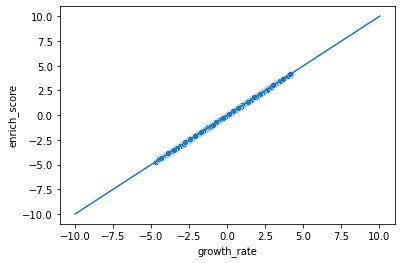

In [8]:
sns.scatterplot(data=df, x='growth_rate',y='enrich_score')
plt.plot([-10,10],[-10,10])
plt.show()

Ok, I believe I did the same calculations as used in the Cuperus paper!

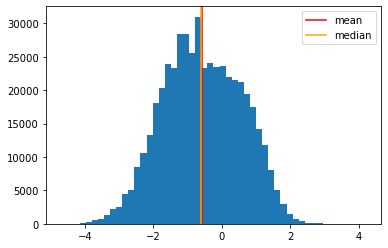

In [9]:
data_mean = np.mean(df['growth_rate'].values)
data_med = np.median(df['growth_rate'].values)
plt.hist(data=df, x='growth_rate',bins=50)
plt.axvline(data_mean, color='red',label='mean')
plt.axvline(data_med, color='orange',label='median')
plt.legend()
plt.show()

### *This is the distribution we're trying to predict*

## Add Shuffled Seq Column
This way we can later compare models to null versions as a negative control


In [10]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

df['shuffled_seq'] = df['UTR'].apply(lambda x: shuffle_seq(x))
df[['UTR','shuffled_seq']]

UTR  \
0       AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...   
1       AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...   
2       AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...   
3       AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...   
4       AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...   
...                                                   ...   
489343  TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...   
489344  TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...   
489345  TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...   
489346  TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...   
489347  TTTTTTTTCGGCATTTATGTAAGTGAGCTTGCGAAGACAAGCTACA...   

                                             shuffled_seq  
0       TCAACAAATTTAAAACGTTACGTAGCAATAATAAGAAAAGTAATAA...  
1       AAGGGTAAACTAACATACGGTAGGAACAAGTACAACGGGACTTACA...  
2       TGAATGATAGAAAACGCAATTATATACGTTTCAATCCACCAAACAA...  
3       ACTTGAGTGAGAACAAACGAATATCTAACTTAAGTTATTCGTTAAG...  
4       CTATAATGTAAAGTAATTGAAAATTACACAGAAAAATTATCAGACC...  
...                                                   ...  
489343  TAAGTAAGACGTCTCATACTGTACATGAAGCAAGTCGGTGCCTAAC...  
489344  TCTCATAATCACTCATTGACCATCCGTTCGGGTTCTTTCGCCCACT...  
489345  GAGTGATGTCCTCTCTTACTAACACAGGTTCTATATAAGAGTACTA...  
489346  GTTTTGGATTATACCCTGTGTCTGGGATGGACTCTATCACCACTTT...  
489347  AGCGATATTGGTCGTTTGCTTATCTGCAATGTATCAGTTATGTAGC...  

[489348 rows x 2 columns]

## Train/test split
First pass: just randomly split between train and test

In [11]:
full_train_df,test_df = tu.quick_split(df)
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

full train: (391478, 12)
test: (97870, 12)
train: (313182, 13)
val: (78296, 13)


In [12]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.violinplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.boxplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True)
    plt.title(f"{title} distribution")
    plt.show()

In [13]:
test_df

index      id                                                UTR  \
4            4       4  AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...   
20          20      20  AAAAAAAACGTGCCGGTATTTGACCGTACGGGACCCTTGCAGCTGT...   
21          21      21  AAAAAAAACTAGCCGGAAGAGGCCTATCAGGTTCAGAGCACCGCCA...   
29          29      29  AAAAAAAAGATCCGCCACGCACCGATTACCGGATAAACAAGCTTAT...   
32          32      32  AAAAAAAAGCAAACAATGCGGACCCGAACGGCATGCCAGAATGTAG...   
...        ...     ...                                                ...   
489324  489324  489324  TTTTTTTACAGCTACGTCCAGCAACATAAATCTTTTCTTAAGACGC...   
489326  489326  489326  TTTTTTTAGTAGCGTCTCGTCCCTGCGAGGAGCCCGTGCTATATCA...   
489327  489327  489327  TTTTTTTATAACCGTCTACTTCGTCCTGCCCTACTAGCAAGTGTTC...   
489330  489330  489330  TTTTTTTATTGAACTTCTACTTCCCGTACCTTCTTATCCAAACGCA...   
489340  489340  489340  TTTTTTTGCGCGGTCTTGGGATGAACGCAACTCAGTGAGAAACTTC...   

        growth_rate  t0   t1  t0_ps  t1_ps       t0_norm       t1_norm  \
4         -0.048841   7    6      8      7  3.466752e-07  3.301502e-07   
20        -1.196243  17    4     18      5  7.800193e-07  2.358216e-07   
21        -0.266707  26   18     27     19  1.170029e-06  8.961219e-07   
29         1.432764  19   76     20     77  8.666881e-07  3.631652e-06   
32        -1.589286  31    5     32      6  1.386701e-06  2.829859e-07   
...             ...  ..  ...    ...    ...           ...           ...   
489324     0.733667  80  154     81    155  3.510087e-06  7.310468e-06   
489326     0.253026  59   70     60     71  2.600064e-06  3.348666e-06   
489327     0.851946  51  111     52    112  2.253389e-06  5.282403e-06   
489330     0.526523   8   13      9     14  3.900097e-07  6.603004e-07   
489340    -0.151698  18   14     19     15  8.233537e-07  7.074647e-07   

        enrich_score                                       shuffled_seq  
4          -0.048841  CTATAATGTAAAGTAATTGAAAATTACACAGAAAAATTATCAGACC...  
20         -1.196243  AACGACGTCTGAGTGGGGCAAATCCACTAATAGCCTAGCTCGTAAT...  
21         -0.266707  GATAAACCAGTCTAGGAGCCACCTAAAATCCGACGACGGCAAAGAT...  
29          1.432764  ACACATAGCAGCATGTGACACGACGTACAACGTATAGAAACGCATG...  
32         -1.589286  CTCACGATAAGCGAGACGTAGAACTCGAATAAGACAGAAGCGCAAA...  
...              ...                                                ...  
489324      0.733667  AACCCTATTGGTTTACGTAGTAAGCCCATAGCACTCAATCTATTTC...  
489326      0.253026  GTATTTACCGAGAGTTTGTTGATGCCCGGCCCTGTCTCGAGTTCAG...  
489327      0.851946  GTTTTCTTGCCCTATCCCTTCTATCTTATAGTCAGCACTTGACCTG...  
489330      0.526523  CTATCTTGTCTTCACTGAGCTCATATAACTTCGTACTATTTATCTC...  
489340     -0.151698  GGCACTTGGTGGGATTTCTATTAGGGAGTAACCTGGTTCTACATTT...  

[97870 rows x 12 columns]

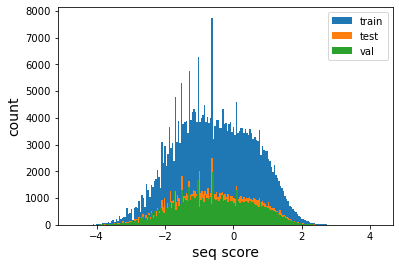

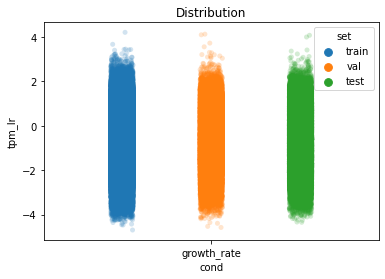

In [14]:
v.plot_train_test_hist(train_df, test_df,score_col='growth_rate',bins=200,val_df=val_df)
v.view_train_test_dist(train_df, test_df,["growth_rate"],id_col='index',val_df=val_df)

In [15]:
split_dfs = {
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

## Load seqs into data loaders

In [16]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

# _RUNNING normal seqs

In [17]:
seq_col = 'UTR'
target_col = 'growth_rate'

dls = tu.build_dataloaders(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
)

ohe_train_dl,ohe_val_dl = dls['ohe']

model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

## run model 

E:209 | train loss:0.699 | val loss: 0.689:  10%|█         | 210/2000 [36:30<5:10:05, 10.39s/it]

EarlyStopping counter: 50 out of 200


E:298 | train loss:0.695 | val loss: 0.691:  15%|█▍        | 299/2000 [51:54<4:55:13, 10.41s/it]

EarlyStopping counter: 50 out of 200


E:348 | train loss:0.695 | val loss: 0.692:  17%|█▋        | 349/2000 [1:00:34<4:46:23, 10.41s/it]

EarlyStopping counter: 100 out of 200


E:398 | train loss:0.693 | val loss: 0.699:  20%|█▉        | 399/2000 [1:09:14<4:37:04, 10.38s/it]

EarlyStopping counter: 150 out of 200


E:448 | train loss:0.693 | val loss: 0.688:  22%|██▏       | 448/2000 [1:17:54<4:29:52, 10.43s/it]

EarlyStopping counter: 200 out of 200
Early stopping


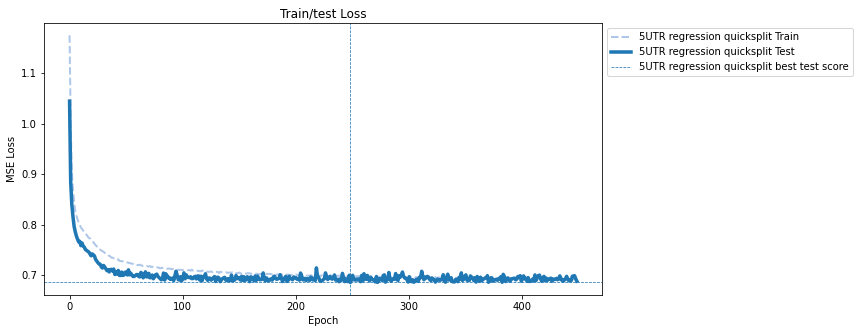

In [22]:
cnn1_name = "5UTR regression quicksplit"
model1 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model1,
    loss_type='regression'
)

In [30]:
path = 'cnn1_name.pth'
torch.save(model1, path)

In [18]:
path = 'cnn1_name.pth'
model1 = torch.load(path)

E:1043 | train loss:0.699 | val loss: 0.701:  21%|██        | 1044/5000 [2:54:38<11:02:22, 10.05s/it]

EarlyStopping counter: 125 out of 500


E:1168 | train loss:0.699 | val loss: 0.701:  23%|██▎       | 1169/5000 [3:15:33<10:40:49, 10.04s/it]

EarlyStopping counter: 250 out of 500


E:1293 | train loss:0.698 | val loss: 0.697:  26%|██▌       | 1294/5000 [3:36:30<10:20:24, 10.04s/it]

EarlyStopping counter: 375 out of 500


E:1418 | train loss:0.696 | val loss: 0.700:  28%|██▊       | 1418/5000 [3:57:26<9:59:47, 10.05s/it] 

EarlyStopping counter: 500 out of 500
Early stopping


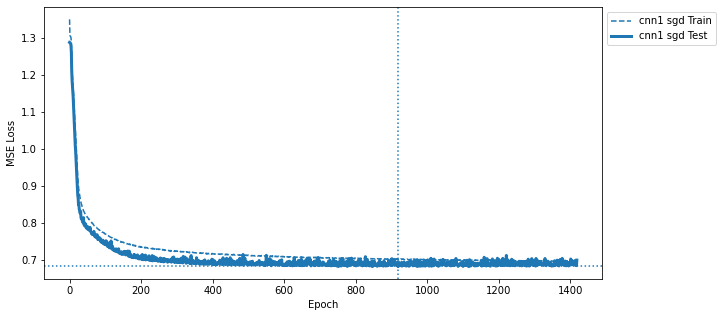

In [31]:
# cnn1_name = 'cnn1 sgd'
# model_res[cnn1_name] = collect_model_stats(
#     cnn1_name,
#     seq_len,
#     'ohe',
#     ohe_train_dl,
#     ohe_val_dl,
#     lr=0.001,
#     ep=5000,
#     pat=500,
# )

In [14]:
# def parity_pred_by_split(model_name,
#                          device,
#                          split_dfs,
#                          locus_col='locus_tag',
#                          seq_col='seq',
#                          target_col="score",
#                          splits=['train','val'],
#                          alpha=0.2
#                         ):
#     '''
#     Given a trained model, get the model's predictions on each split
#     of the data and create parity plots of the y predictions vs actual ys
#     '''
#     # init subplots
#     fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
#     pred_dfs = {}
    
#     def parity_plot(model_title,ytrue,ypred,rigid=True):
#         axs[i].scatter(ytrue, ypred, alpha=alpha)

#         r2 = r2_score(ytrue,ypred)
#         pr = pearsonr(ytrue,ypred)[0]
#         sp = spearmanr(ytrue,ypred).correlation

#         # y=x line
#         xpoints = ypoints = plt.xlim()
#         if rigid:
#             axs[i].set_ylim(min(xpoints),max(xpoints)) 
#         axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
#         axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
#         axs[i].set_xlabel("Actual Score",fontsize=14)
#         axs[i].set_ylabel("Predicted Score",fontsize=14)
    
#     for i,split in enumerate(splits):
#         print(f"{split} split")
#         df = split_dfs[split]
#         loci = df[locus_col].values
#         seqs = list(df[seq_col].values)        
#         ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
#         labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
#     #dfs = {} # key: model name, value: parity_df
    
#         # initialize prediction df with just locus col
#         pred_df = df[[locus_col]]
#         pred_df['truth'] = df[target_col]
#         print(f"Running {model_name}")
        
#         model = model_res[model_name]['model']
#         # ask model to predict on seqs
#         preds = model(ohe_seqs.float()).tolist()
#         # preds is a tensor converted to a list, 
#         # single elements returned as a list, hence x[0]
#         pred_df['pred'] = [x[0] for x in preds]
        
#         # do I want the result dfs? revise if so
#         #dfs[model_name] = pred_df
        
#         # plot stuff
#         ytrue = pred_df['truth'].values
#         ypred = pred_df['pred'].values
        
#         #plt.subplot(len(splits),i+1,1)
#         model_title = split
#         parity_plot(model_title,ytrue,ypred,rigid=True)
        
#         # save predictions
#         pred_dfs[split] = pred_df
    
    
#     plt.suptitle(model_name,fontsize=14)
#     plt.tight_layout()
#     plt.show()
    
#     return pred_dfs

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Predicting for 5UTR regression quicksplit
test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Predicting for 5UTR regression quicksplit


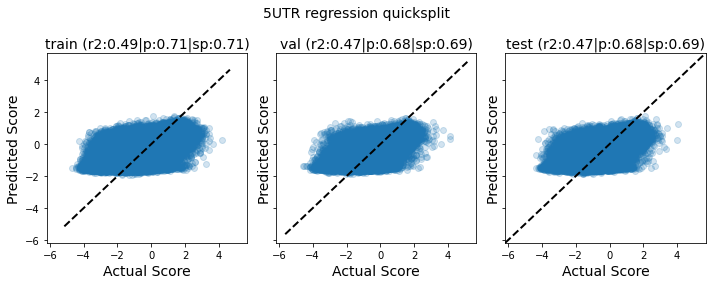

In [19]:
cnn1_name = "5UTR regression quicksplit"
pred_dfs[cnn1_name] = tu.parity_pred_by_split(
    model1,
    cnn1_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
                    )

In [ ]:
#mmmmkkkkkk

E:125 | train loss:0.704 | val loss: 0.688:   6%|▋         | 126/2000 [21:42<5:22:57, 10.34s/it]

EarlyStopping counter: 50 out of 200


E:263 | train loss:0.699 | val loss: 0.698:  13%|█▎        | 264/2000 [45:29<4:58:47, 10.33s/it]

EarlyStopping counter: 50 out of 200


E:313 | train loss:0.698 | val loss: 0.690:  16%|█▌        | 314/2000 [54:05<4:50:02, 10.32s/it]

EarlyStopping counter: 100 out of 200


E:363 | train loss:0.698 | val loss: 0.704:  18%|█▊        | 364/2000 [1:02:42<4:42:21, 10.36s/it]

EarlyStopping counter: 150 out of 200


E:413 | train loss:0.697 | val loss: 0.696:  21%|██        | 413/2000 [1:11:19<4:34:04, 10.36s/it]

EarlyStopping counter: 200 out of 200
Early stopping


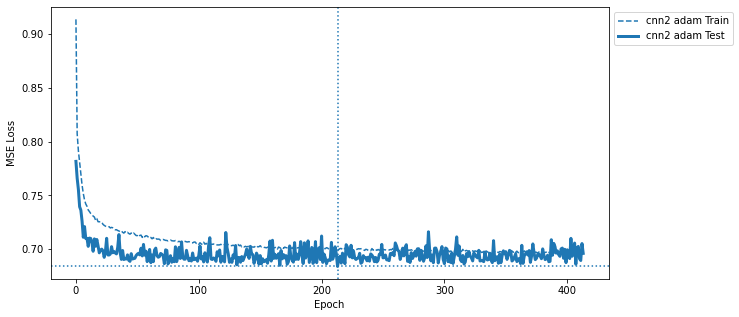

In [34]:
# cnn2_name = 'cnn2 adam'
# model_res[cnn2_name] = collect_model_stats(
#     cnn2_name,
#     seq_len,
#     'ohe',
#     ohe_train_dl,
#     ohe_val_dl,
#     lr=0.001,
#     ep=2000,
#     pat=200,
#     opt=torch.optim.Adam
# )

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn2 adam


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn2 adam


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn2 adam


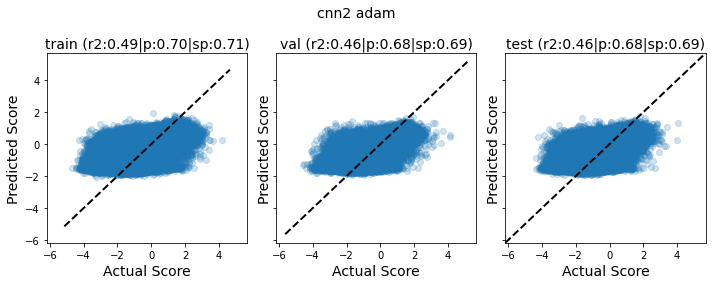

In [35]:
# pred_dfs = parity_pred_by_split(cnn2_name,
#                                 DEVICE,
#                                 locus_col='index',
#                                 seq_col=seq_col_name,
#                                 target_col=target_col_name,
#                                 splits=['train','val','test']
#                     )

In [ ]:
# what about this?

E:161 | train loss:0.700 | val loss: 0.689:   8%|▊         | 162/2000 [28:07<5:19:03, 10.42s/it]

EarlyStopping counter: 50 out of 200


E:211 | train loss:0.698 | val loss: 0.695:  11%|█         | 212/2000 [36:48<5:10:10, 10.41s/it]

EarlyStopping counter: 100 out of 200


E:261 | train loss:0.699 | val loss: 0.692:  13%|█▎        | 262/2000 [45:29<5:02:34, 10.45s/it]

EarlyStopping counter: 150 out of 200


E:311 | train loss:0.698 | val loss: 0.698:  16%|█▌        | 311/2000 [54:14<4:54:33, 10.46s/it]

EarlyStopping counter: 200 out of 200
Early stopping


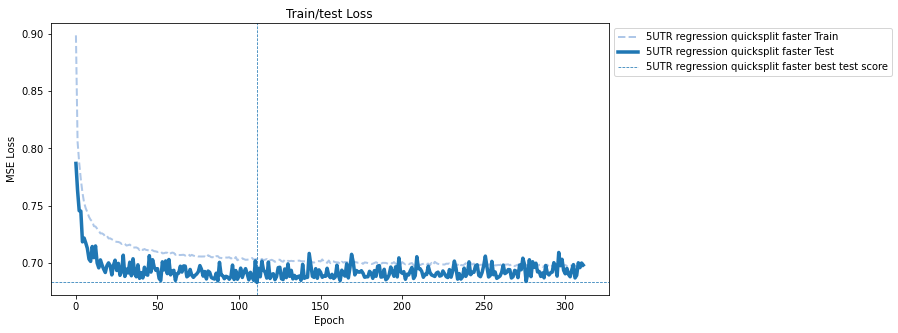

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit faster


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit faster


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Predicting for 5UTR regression quicksplit faster


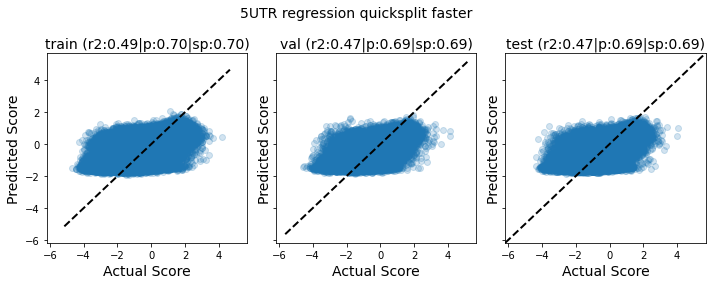

In [20]:
cnn3_name = "5UTR regression quicksplit faster"
model3 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='regression'
)

pred_dfs[cnn3_name] = tu.parity_pred_by_split(
    model3,
    cnn3_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
                    )

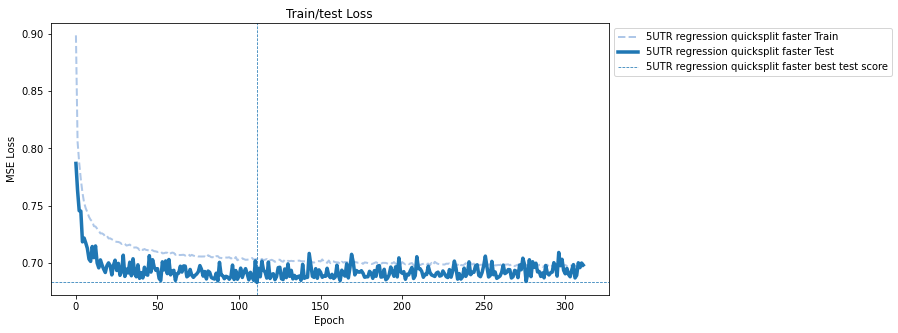

In [21]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

# try again with shuffled seqs

In [23]:
seq_col_name = 'shuffled_seq'
target_col_name = 'growth_rate'

# Dfs from further spliting train into train and val
dls_shuff = tu.build_dataloaders(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

shuff_ohe_train_dl,shuff_ohe_val_dl = dls_shuff['ohe']

E:70 | train loss:1.190 | val loss: 1.202:   4%|▎         | 71/2000 [12:26<5:37:50, 10.51s/it]

EarlyStopping counter: 50 out of 200


E:120 | train loss:1.178 | val loss: 1.206:   6%|▌         | 121/2000 [21:11<5:28:40, 10.49s/it]

EarlyStopping counter: 100 out of 200


E:170 | train loss:1.171 | val loss: 1.211:   9%|▊         | 171/2000 [29:57<5:19:41, 10.49s/it]

EarlyStopping counter: 150 out of 200


E:220 | train loss:1.166 | val loss: 1.212:  11%|█         | 220/2000 [38:41<5:13:05, 10.55s/it]

EarlyStopping counter: 200 out of 200
Early stopping


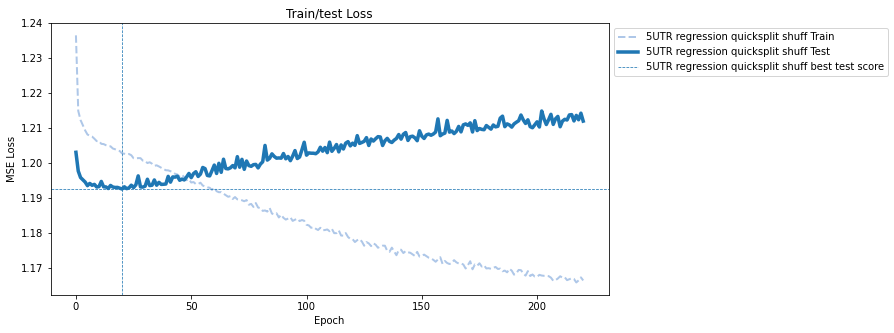

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit shuff


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit shuff


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Predicting for 5UTR regression quicksplit shuff


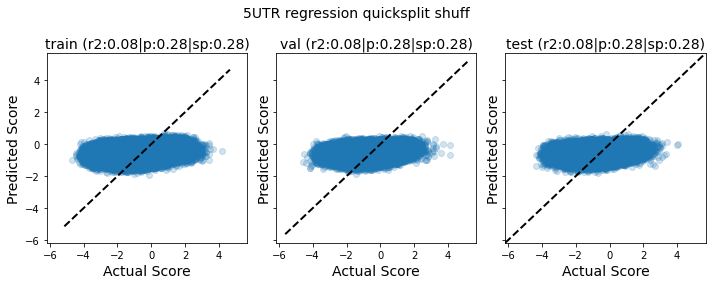

In [25]:
# cnn4_name = 'cnn4 sgd shuff'
# model_res[cnn4_name] = collect_model_stats(
#     cnn4_name,
#     seq_len,
#     'ohe',
#     shuff_ohe_train_dl,
#     shuff_ohe_val_dl,
#     lr=0.001,
#     ep=2000,
#     pat=200,
# )

cnn4_name = "5UTR regression quicksplit shuff"
model4 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn4_name] = tu.collect_model_stats(
    cnn4_name,
    seq_len,
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model4,
    loss_type='regression'
)

pred_dfs[cnn4_name] = tu.parity_pred_by_split(
    model4,
    cnn4_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
                    )

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 sgd shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 sgd shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn4 sgd shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


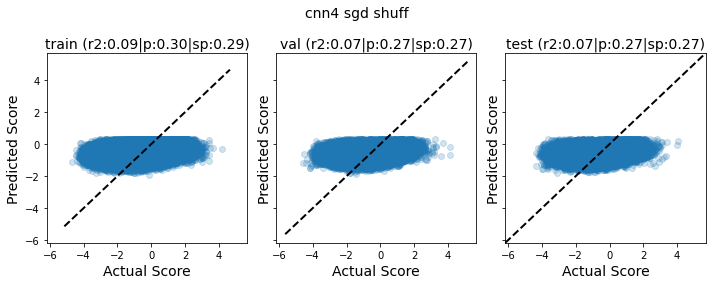

In [41]:
# pred_dfs = parity_pred_by_split(cnn4_name,
#                      DEVICE,
#                      locus_col='index',
#                      seq_col=seq_col_name,
#                      target_col=target_col_name,
#                      splits=['train','val','test']
#                     )

E:54 | train loss:1.185 | val loss: 1.206:   3%|▎         | 55/2000 [09:31<5:37:23, 10.41s/it]

EarlyStopping counter: 50 out of 200


E:104 | train loss:1.177 | val loss: 1.208:   5%|▌         | 105/2000 [18:11<5:27:42, 10.38s/it]

EarlyStopping counter: 100 out of 200


E:154 | train loss:1.172 | val loss: 1.214:   8%|▊         | 155/2000 [26:51<5:19:29, 10.39s/it]

EarlyStopping counter: 150 out of 200


E:204 | train loss:1.169 | val loss: 1.211:  10%|█         | 204/2000 [35:31<5:12:46, 10.45s/it]

EarlyStopping counter: 200 out of 200
Early stopping


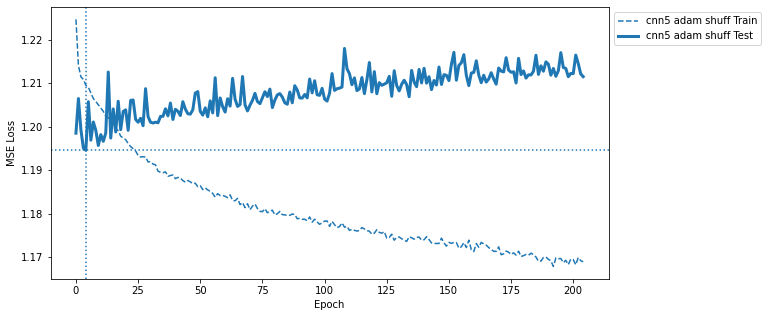

In [42]:
# cnn5_name = 'cnn5 adam shuff'
# model_res[cnn5_name] = collect_model_stats(
#     cnn5_name,
#     seq_len,
#     'ohe',
#     shuff_ohe_train_dl,
#     shuff_ohe_val_dl,
#     lr=0.001,
#     ep=2000,
#     pat=200,
#     opt=torch.optim.Adam
# )

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn5 adam shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn5 adam shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn5 adam shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


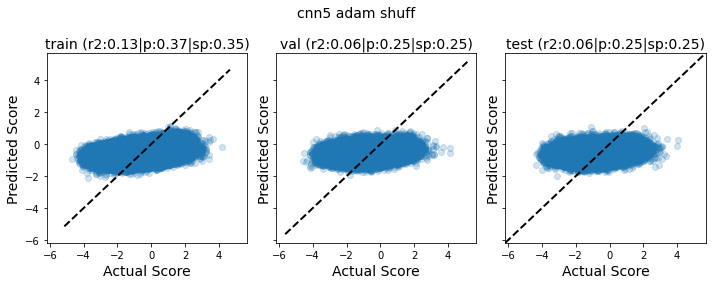

In [43]:
# pred_dfs = parity_pred_by_split(cnn5_name,
#                                 DEVICE,
#                                 locus_col='index',
#                                 seq_col=seq_col_name,
#                                 target_col=target_col_name,
#                                 splits=['train','val','test']
#                     )

E:68 | train loss:1.198 | val loss: 1.196:   3%|▎         | 69/2000 [11:58<5:34:45, 10.40s/it]

EarlyStopping counter: 50 out of 200


E:118 | train loss:1.188 | val loss: 1.205:   6%|▌         | 119/2000 [20:39<5:27:48, 10.46s/it]

EarlyStopping counter: 100 out of 200


E:168 | train loss:1.180 | val loss: 1.214:   8%|▊         | 169/2000 [29:20<5:17:31, 10.41s/it]

EarlyStopping counter: 150 out of 200


E:218 | train loss:1.173 | val loss: 1.217:  11%|█         | 218/2000 [38:00<5:10:45, 10.46s/it]

EarlyStopping counter: 200 out of 200
Early stopping


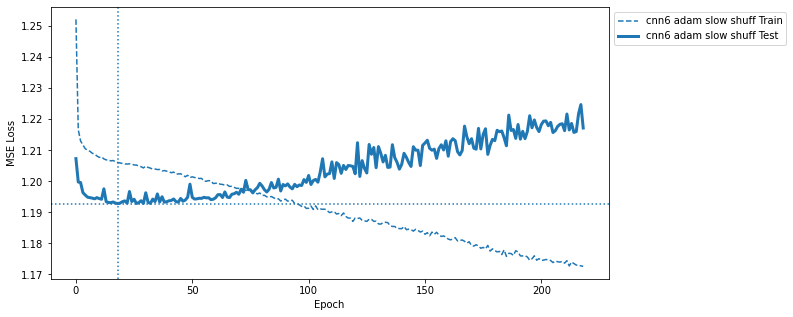

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn6 adam slow shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn6 adam slow shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn6 adam slow shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


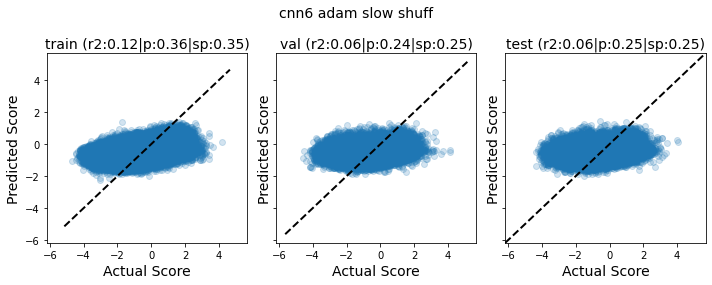

In [44]:
# cnn6_name = 'cnn6 adam slow shuff'
# model_res[cnn6_name] = collect_model_stats(
#     cnn6_name,
#     seq_len,
#     'ohe',
#     shuff_ohe_train_dl,
#     shuff_ohe_val_dl,
#     lr=0.0001,
#     ep=2000,
#     pat=200,
#     opt=torch.optim.Adam
# )

# pred_dfs = parity_pred_by_split(cnn6_name,
#                      DEVICE,
#                      locus_col='index',
#                      seq_col=seq_col_name,
#                      target_col=target_col_name,
#                      splits=['train','val','test']
#                     )

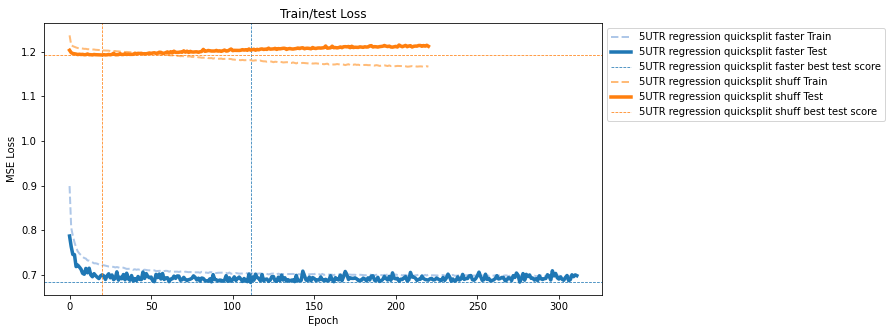

In [26]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [ ]:
# how does normal vs shuff look?

# Now try with top 5% of samples with most reads as test set

In [27]:
def top_n_split(df, n, sort_col):
    '''
    Given a value n, take the top n% of reads and use those as the test split.
    '''
    sorted_df = df.sort_values(sort_col,ascending=False)
    
    total_samples = df.shape[0]
    num_test_samples = int(n*total_samples)
    test_df = sorted_df.head(num_test_samples)
    train_df = sorted_df.tail(total_samples - num_test_samples)
    
    return train_df, test_df

In [28]:
full_train_df,test_df = top_n_split(df, 0.05, 't0')
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

split_dfs = {
    #'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df.reset_index(),   
}

full train: (464881, 11)
test: (24467, 11)
train: (371904, 12)
val: (92977, 12)


In [29]:
test_df.reset_index()

index      id                                                UTR  \
0      232749  232749  CTAGTACAGAGCAGAAAGCCCTTATACATTAGGACCTTTGCAGCAC...   
1       65465   65465  ACGTCAATCCCTGTCCCGTGCGTTCCTGAGCCTTATGACATCTACG...   
2      221380  221380  CGTACAACTAAATGGGATCTCCTTTGAACTGTATTCCTGAACCAGC...   
3      143417  143417  CAACCAAGTGGTCACACAAAACGCAGAGTACAGTGCTGCCAAAACA...   
4       26512   26512  AAGCCTGTCTCGAAGAGCATACCGTATCTACGGAAGGCCAGTCCAG...   
...       ...     ...                                                ...   
24462  103065  103065  AGTTTGCGAGACTGTACTGTCTACTTTGTAATTATCGACGAATCCT...   
24463   97140   97140  AGTAGAAACAAGTTTGGGAACACACGCGCCGAATGCCCCTAACTCC...   
24464  372981  372981  TAATAGCAAAGAACGTCACGGTTCTCCTATTAGTCCGCGGTTCTAT...   
24465    9214    9214  AAAGTCTTGAGGAACCAAGACCATGTAAGCTTCAAGTACAACGGAC...   
24466   25755   25755  AAGCACTCCGGATACCGAACAAGCATCGACGGATTCAGAGTGATCC...   

       growth_rate   t0    t1  t0_ps  t1_ps   t0_norm   t1_norm  enrich_score  \
0         0.851569  757  1631    758   1632  0.000033  0.000077      0.851569   
1        -1.293179  590   148    591    149  0.000026  0.000007     -1.293179   
2        -0.757277  498   214    499    215  0.000022  0.000010     -0.757277   
3         0.390326  413   561    414    562  0.000018  0.000027      0.390326   
4        -1.329617  361    87    362     88  0.000016  0.000004     -1.329617   
...            ...  ...   ...    ...    ...       ...       ...           ...   
24462     0.952779  101   242    102    243  0.000004  0.000011      0.952779   
24463     0.279999  101   123    102    124  0.000004  0.000006      0.279999   
24464     1.205921  101   312    102    313  0.000004  0.000015      1.205921   
24465    -0.756093  101    43    102     44  0.000004  0.000002     -0.756093   
24466     1.101625  101   281    102    282  0.000004  0.000013      1.101625   

                                            shuffled_seq  
0      GCTTGTAATCGCACAATAATCGCACATTACCGAGGGAAACTTGGTC...  
1      CGTCCTCTATTCTCTACTTGCCTCGACCTGCCAGTCTAAGTGTCCA...  
2      TTAATCCGCATGACCGACGAACGGTCGTAATTATCGCCACCAAGAT...  
3      CAGACCATCCGGCTGGAACAAACTGAACAACAAAGAATGACCTGGA...  
4      ACAGGAGTGGACCCAGCACTGTATTCAAGAGCCGCAGTGGTCCCGT...  
...                                                  ...  
24462  CACGATTACAATATCCGGTTATATTGTCCTTACCGATTATGTTAAG...  
24463  GGCGTTAGCGGCACAAGTCTTTAAAATAAACCCCCAACTGGGCCAA...  
24464  TATCGTGGCGTCCTAATCTTAATTACAAGTCAGAAGCAGTAGCCTA...  
24465  AAATTGTAACAAAACCGCGCAAGCGAGTTCAGACACGATCTCAATG...  
24466  TTCAGCACGTAATCTGGAAGGGCGATAGACTGACCAGCCTAGAAGA...  

[24467 rows x 12 columns]

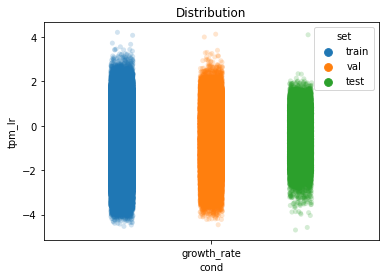

In [30]:
v.view_train_test_dist(train_df, test_df,["growth_rate"],id_col='index',val_df=val_df)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


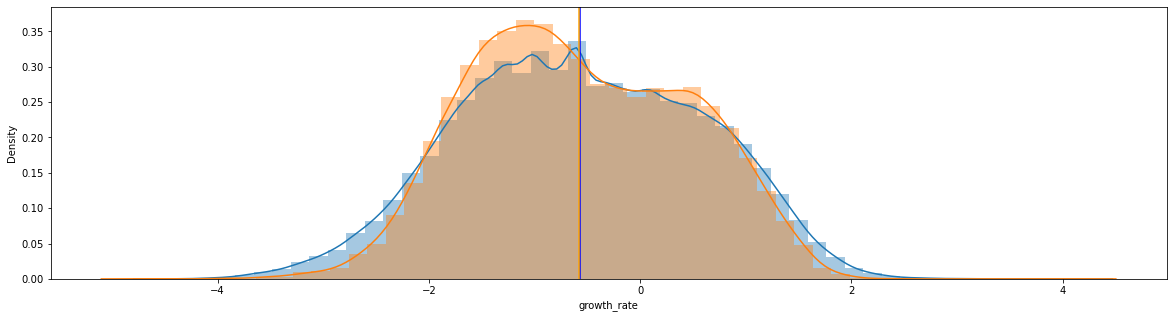

In [31]:
fig = plt.figure(figsize=(20,5))
sns.distplot(train_df['growth_rate'])
sns.distplot(test_df['growth_rate'])
plt.axvline(np.mean(train_df['growth_rate'].values),color='blue')
plt.axvline(np.mean(test_df['growth_rate'].values),color='orange')
#sns.distplot(val_df['growth_rate'])

In [32]:
dataset_types = [
    DatasetSpec('ohe'),
]

seq_col_name = 'UTR'
target_col_name = 'growth_rate'

# Dfs for the full train/test split
# final_dls = tu.build_dataloaders_single(
#     full_train_df, 
#     test_df, 
#     dataset_types,
#     seq_col=seq_col_name,
#     target_col=target_col_name
# )

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)


ohe_train_dl,ohe_val_dl = dls['ohe']

model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col_name].values[0])

E:229 | train loss:0.714 | val loss: 0.722:  12%|█▏        | 230/2000 [47:47<6:07:51, 12.47s/it]

EarlyStopping counter: 50 out of 200


E:279 | train loss:0.713 | val loss: 0.726:  14%|█▍        | 280/2000 [58:10<5:57:20, 12.47s/it]

EarlyStopping counter: 100 out of 200


E:329 | train loss:0.710 | val loss: 0.721:  16%|█▋        | 330/2000 [1:08:33<5:46:41, 12.46s/it]

EarlyStopping counter: 150 out of 200


E:379 | train loss:0.708 | val loss: 0.714:  19%|█▉        | 379/2000 [1:18:56<5:37:37, 12.50s/it]

EarlyStopping counter: 200 out of 200
Early stopping


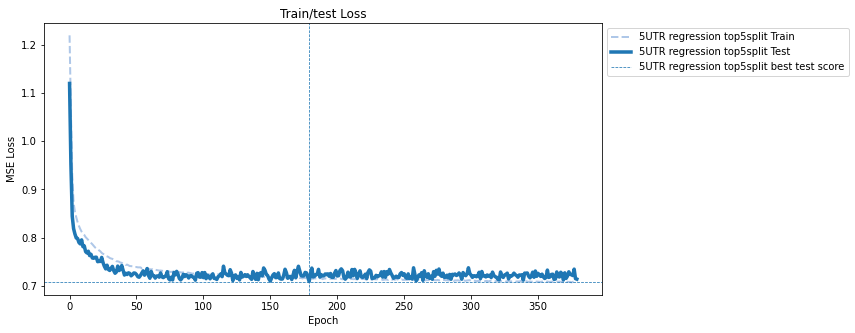

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression top5split


RuntimeError: CUDA out of memory. Tried to allocate 1.60 GiB (GPU 0; 14.76 GiB total capacity; 10.64 GiB already allocated; 72.75 MiB free; 12.66 GiB reserved in total by PyTorch)

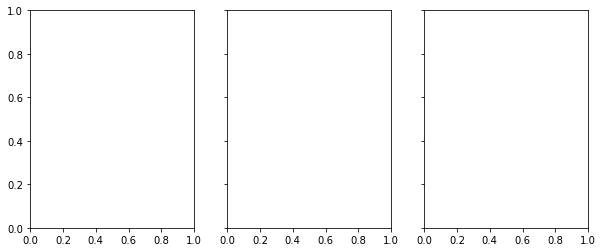

In [33]:
# cnn7_name = 'cnn7 sgd top5'
# model_res[cnn7_name] = collect_model_stats(
#     cnn7_name,
#     seq_len,
#     'ohe',
#     ohe_train_dl,
#     ohe_val_dl,
#     lr=0.001,
#     ep=2000,
#     pat=200,
# )

# pred_dfs[cnn7_name] = parity_pred_by_split(cnn7_name,
#                                 DEVICE,
#                                 split_dfs,
#                                 locus_col='index',
#                                 seq_col=seq_col_name,
#                                 target_col=target_col_name,
#                                 splits=['train','val','test']
#                     )

cnn7_name = "5UTR regression top5split"
model7 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn7_name] = tu.collect_model_stats(
    cnn7_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model7,
    loss_type='regression'
)

pred_dfs[cnn7_name] = tu.parity_pred_by_split(
    model7,
    cnn7_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
                    )

val split
Predicting for 5UTR regression top5split
test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:925: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


Predicting for 5UTR regression top5split


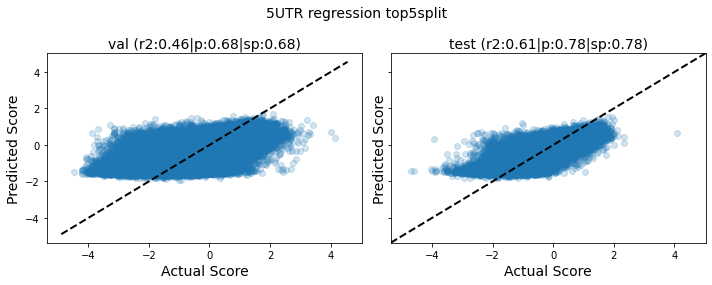

In [35]:
pred_dfs[cnn7_name] = tu.parity_pred_by_split(
    model7,
    cnn7_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['val','test']
                    )

In [ ]:
# PCIK UP HERE!!




In [36]:
locus_col = 'id'
seq_col = 'UTR'
target_col = 'growth_rate'
split='test'
model_name = cnn7_name
model = model7


my_df = split_dfs[split]
loci = my_df[locus_col].values
seqs = list(my_df[seq_col].values)        
ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)

# initialize prediction df with just locus col
pred_df = my_df[[locus_col]]
pred_df['truth'] = my_df[target_col]
print(f"Predicting for {model_name}")


# ask model to predict on seqs
preds = model(ohe_seqs.float()).tolist()
# preds is a tensor converted to a list, 
# single elements returned as a list, hence x[0]
pred_df['pred'] = [x[0] for x in preds]

# do I want the result dfs? revise if so
#dfs[model_name] = pred_df

# plot stuff
ytrue = pred_df['truth'].values
ypred = pred_df['pred'].values


Predicting for 5UTR regression top5split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
pred_df

id     truth      pred
0      232749  0.851569  0.502352
1       65465 -1.293179 -1.428755
2      221380 -0.757277  0.284542
3      143417  0.390326  0.756699
4       26512 -1.329617  0.011446
...       ...       ...       ...
24462  103065  0.952779  0.563077
24463   97140  0.279999 -0.425001
24464  372981  1.205921  0.685809
24465    9214 -0.756093 -1.460835
24466   25755  1.101625  0.591981

[24467 rows x 3 columns]

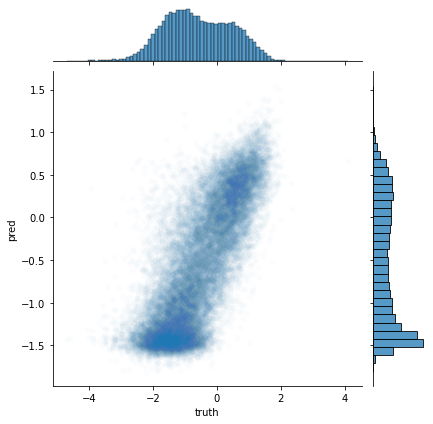

In [44]:
sns.jointplot(data = pred_df, x='truth',y='pred',alpha=0.02)


In [39]:
from scipy import stats


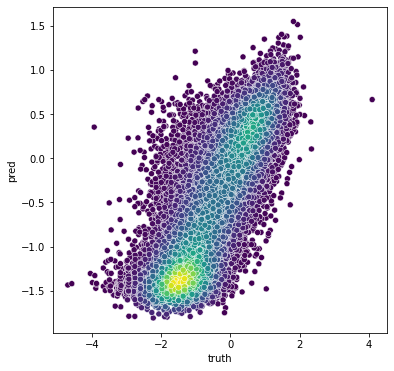

In [45]:
values = np.vstack([pred_df['truth'], pred_df['pred']])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=pred_df,
    x="truth",
    y="pred",
    c=kernel,
    cmap="viridis",
    ax=ax,
)
# xpoints = ypoints = plt.xlim()
# plt.ylim(min(xpoints),max(xpoints))
plt.show()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predicting for 5UTR regression top5split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Predicting for 5UTR regression top5split


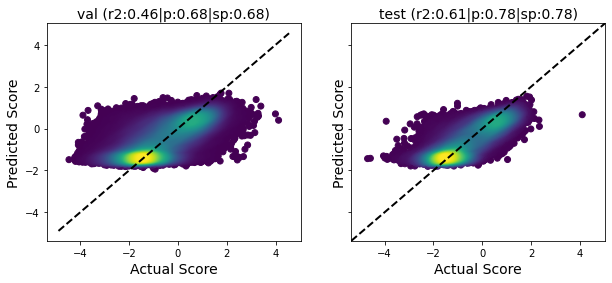

In [50]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True,figsize=(10,4))

def parity_plot(title,ytrue,ypred,rigid=True,dense_color=False):
    '''
    Individual parity plot for a specific split
    '''
    if dense_color:
        # get color by point density kernel
        # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
        values = np.vstack([ytrue, ypred])
        kernel = stats.gaussian_kde(values)(values)

        # Sort the points by density, so that the densest points are plotted last
        idx = kernel.argsort()
        ytrue, ypred, kernel = ytrue[idx], ypred[idx], kernel[idx]

        axs[i].scatter(ytrue, ypred, c=kernel)
    
    else:
        axs[i].scatter(ytrue, ypred, alpha=0.2)

    r2 = r2_score(ytrue,ypred)
    pr = pearsonr(ytrue,ypred)[0]
    sp = spearmanr(ytrue,ypred).correlation

    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        axs[i].set_ylim(min(xpoints),max(xpoints)) 
    axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
    axs[i].set_title(f"{title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
    axs[i].set_xlabel("Actual Score",fontsize=14)
    axs[i].set_ylabel("Predicted Score",fontsize=14)
    
    return r2, pr, sp
    
locus_col = 'id'
seq_col = 'UTR'
target_col = 'growth_rate'
split='test'
model_name = cnn7_name
model = model7

for i, split in enumerate(['val','test']):
    my_df = split_dfs[split]
    loci = my_df[locus_col].values
    seqs = list(my_df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)

    # initialize prediction df with just locus col
    pred_df = my_df[[locus_col]]
    pred_df['truth'] = my_df[target_col]
    print(f"Predicting for {model_name}")


    # ask model to predict on seqs
    preds = model(ohe_seqs.float()).tolist()
    # preds is a tensor converted to a list, 
    # single elements returned as a list, hence x[0]
    pred_df['pred'] = [x[0] for x in preds]

    # do I want the result dfs? revise if so
    #dfs[model_name] = pred_df

    # plot stuff
    ytrue = pred_df['truth'].values
    ypred = pred_df['pred'].values
    
    split_title = split
    r2,pr,sp = parity_plot(split_title,ytrue,ypred,rigid=True,dense_color=True)

I want to start reducing the dataset size but this notebook seems outta cuda memory. 

Can I set it up to run reductions and shuffled seq and collect the data?

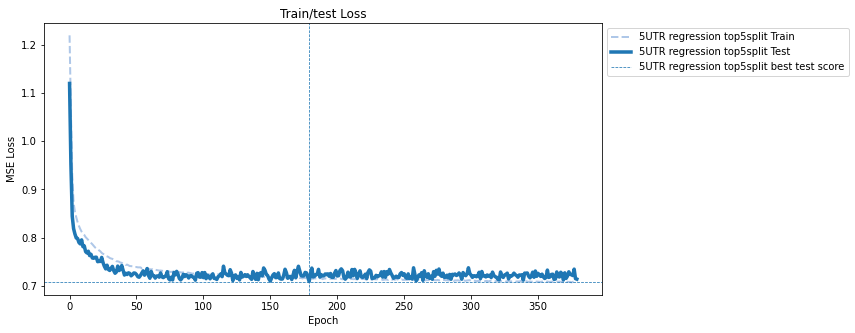

In [51]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [52]:
[x for x in model_res]

['5UTR regression top5split']

(-4.0, 4.0)

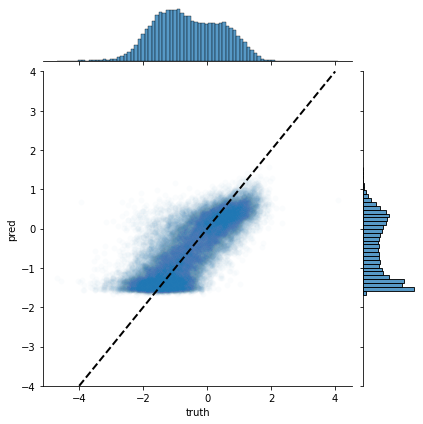

In [88]:
#fig = plt.figure(figsize=(10,10))
plot = sns.jointplot(data = pred_dfs['test'], x='truth',y='pred',alpha=0.02)
#plt.scatter(pred_dfs['test']['truth'],pred_dfs['test']['pred'])
xpoints = ypoints = (-4,4)
plot.ax_joint.plot([-4,4],[-4,4], linestyle='--', color='k', lw=2,)# scalex=False, scaley=False)
plt.ylim(min(xpoints),max(xpoints)) 


# Start reducing the dataset size

In [34]:
df

index                                                UTR  \
0            0  AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...   
1            1  AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...   
2            2  AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...   
3            3  AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...   
4            4  AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...   
...        ...                                                ...   
489343  489343  TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...   
489344  489344  TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...   
489345  489345  TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...   
489346  489346  TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...   
489347  489347  TTTTTTTTCGGCATTTATGTAAGTGAGCTTGCGAAGACAAGCTACA...   

        growth_rate  t0   t1  t0_ps  t1_ps       t0_norm       t1_norm  \
0         -1.237065  14    3     15      4  6.500161e-07  1.886572e-07   
1          1.288663  14   49     15     50  6.500161e-07  2.358216e-06   
2         -0.608457  13    6     14      7  6.066817e-07  3.301502e-07   
3         -1.093964  12    3     13      4  5.633473e-07  1.886572e-07   
4         -0.048841   7    6      8      7  3.466752e-07  3.301502e-07   
...             ...  ..  ...    ...    ...           ...           ...   
489343     1.380601  80  295     81    296  3.510087e-06  1.396064e-05   
489344     0.796187  26   54     27     55  1.170029e-06  2.594037e-06   
489345     0.731318  10   20     11     21  4.766785e-07  9.904505e-07   
489346    -0.944929  13    4     14      5  6.066817e-07  2.358216e-07   
489347    -2.112534   8    0      9      1  3.900097e-07  4.716431e-08   

        enrich_score                                       shuffled_seq  
0          -1.237065  TCAACAAATTTAAAACGTTACGTAGCAATAATAAGAAAAGTAATAA...  
1           1.288663  AAGGGTAAACTAACATACGGTAGGAACAAGTACAACGGGACTTACA...  
2          -0.608457  TGAATGATAGAAAACGCAATTATATACGTTTCAATCCACCAAACAA...  
3          -1.093964  ACTTGAGTGAGAACAAACGAATATCTAACTTAAGTTATTCGTTAAG...  
4          -0.048841  CTATAATGTAAAGTAATTGAAAATTACACAGAAAAATTATCAGACC...  
...              ...                                                ...  
489343      1.380601  TAAGTAAGACGTCTCATACTGTACATGAAGCAAGTCGGTGCCTAAC...  
489344      0.796187  TCTCATAATCACTCATTGACCATCCGTTCGGGTTCTTTCGCCCACT...  
489345      0.731318  GAGTGATGTCCTCTCTTACTAACACAGGTTCTATATAAGAGTACTA...  
489346     -0.944929  GTTTTGGATTATACCCTGTGTCTGGGATGGACTCTATCACCACTTT...  
489347     -2.112534  AGCGATATTGGTCGTTTGCTTATCTGCAATGTATCAGTTATGTAGC...  

[489348 rows x 11 columns]

In [19]:
# randomly reduce by some fraction
def reduction_loop(reduction,seq_col_name,target_col_name):#, train_df,val_df,test_df):
    '''
    Loop to down sample train/val/test sets
    '''

    red_train_df = train_df.sample(frac=reduction)
    red_val_df = val_df.sample(frac=reduction)
    red_test_df = test_df.sample(frac=reduction)

    print("train reduced",red_train_df.shape)
    print("val reduced",red_val_df.shape)
    print("test reduced",red_test_df.shape)

    red_split_dfs = {
        #'full_train':full_train_df,
        'train':red_train_df,
        'val':red_val_df,
        'test':red_test_df.reset_index(),   
    }

    # plots
    view_train_test_dist(red_train_df, red_test_df,["growth_rate"],"TPM",id_col='index',val_df=red_val_df)

    fig = plt.figure(figsize=(20,5))
    sns.distplot(red_train_df['growth_rate'])
    sns.distplot(red_test_df['growth_rate'])
    plt.axvline(np.mean(red_train_df['growth_rate'].values),color='blue')
    plt.axvline(np.mean(red_test_df['growth_rate'].values),color='orange')
    plt.show()


    # Dfs from further spliting train into train and val
    red_dls = tu.build_dataloaders_single(
        red_train_df, 
        red_val_df, 
        dataset_types,
        seq_col=seq_col_name,
        target_col=target_col_name,
    )

    red_ohe_train_dl,red_ohe_val_dl = red_dls['ohe']
    
    return red_ohe_train_dl, red_ohe_val_dl, red_split_dfs

In [25]:
train_df.shape

(371904, 13)

In [43]:
train_df.sample(frac=1.0).shape

(371904, 13)

In [36]:
#pred_dfs = {}
split_sizes = {}

train reduced (92976, 12)
val reduced (23244, 12)
test reduced (6117, 11)


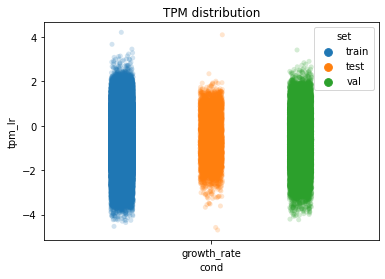

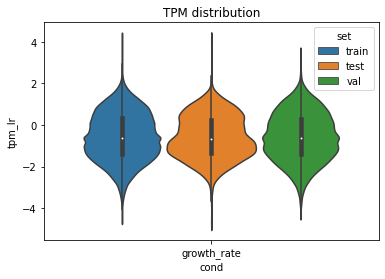

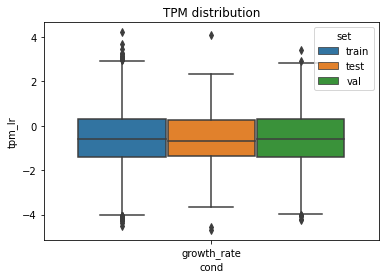

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


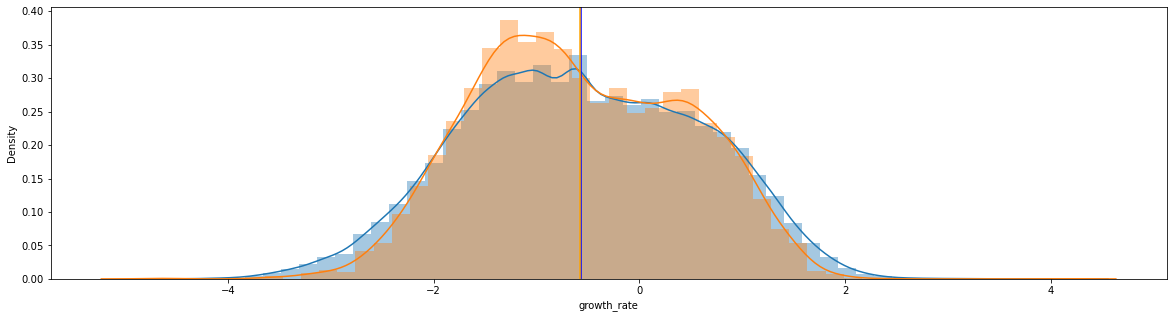


0.25:{'train': 92976, 'val': 23244, 'test': 6117}


E:173 | train loss:0.696 | val loss: 0.772:   3%|▎         | 174/5000 [09:06<4:11:57,  3.13s/it]

EarlyStopping counter: 125 out of 500


E:298 | train loss:0.684 | val loss: 0.775:   6%|▌         | 299/5000 [15:40<4:05:33,  3.13s/it]

EarlyStopping counter: 250 out of 500


E:423 | train loss:0.679 | val loss: 0.780:   8%|▊         | 424/5000 [22:12<3:59:23,  3.14s/it]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.675 | val loss: 0.786:  11%|█         | 548/5000 [28:46<3:53:43,  3.15s/it]

EarlyStopping counter: 500 out of 500
Early stopping


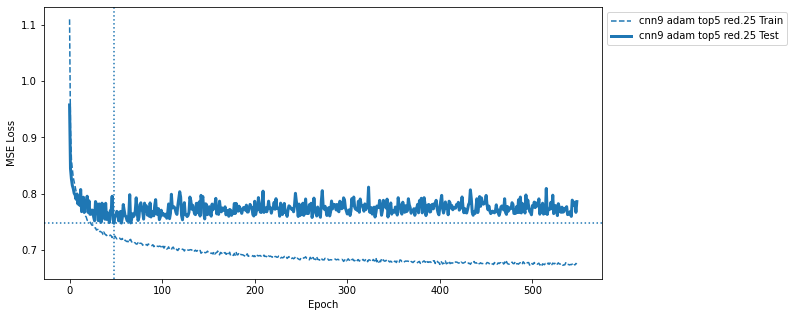

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn9 adam top5 red.25


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn9 adam top5 red.25
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn9 adam top5 red.25


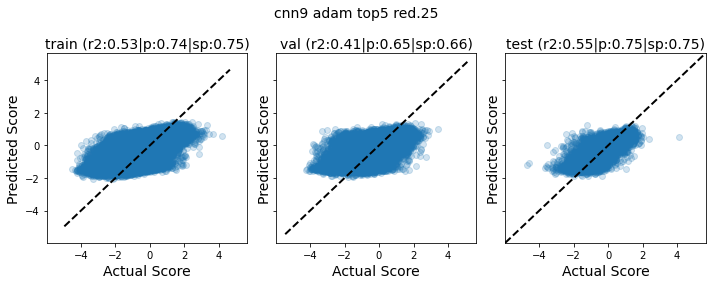

In [169]:
r = 0.25
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r)

split_sizes[r] = {}
for split in red_split_dfs:
    split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')

cnn9_name = 'cnn9 adam top5 red.25'
model_res[cnn9_name] = collect_model_stats(
    cnn9_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn9_name] = parity_pred_by_split(cnn9_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )



train reduced (9298, 12)
val reduced (2324, 12)
test reduced (612, 11)


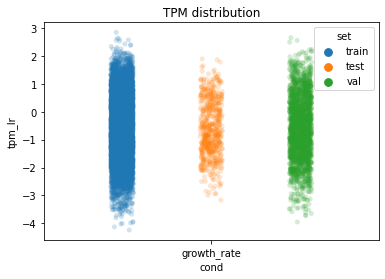

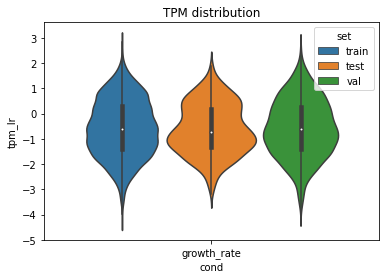

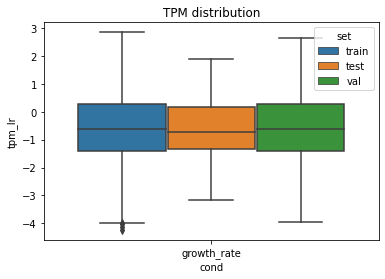

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


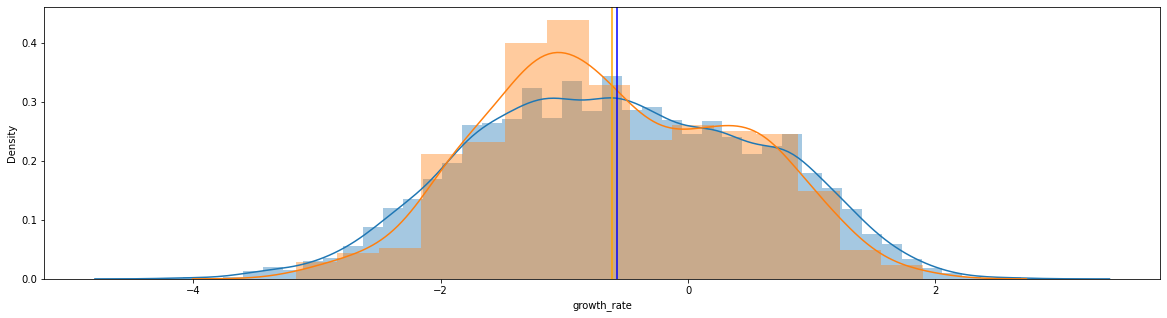


0.025:{'train': 9298, 'val': 2324, 'test': 612}


E:141 | train loss:0.404 | val loss: 1.023:   3%|▎         | 142/5000 [00:44<25:07,  3.22it/s]

EarlyStopping counter: 125 out of 500


E:266 | train loss:0.369 | val loss: 1.035:   5%|▌         | 267/5000 [01:23<24:27,  3.23it/s]

EarlyStopping counter: 250 out of 500


E:391 | train loss:0.339 | val loss: 1.047:   8%|▊         | 392/5000 [02:01<23:46,  3.23it/s]

EarlyStopping counter: 375 out of 500


E:516 | train loss:0.336 | val loss: 1.041:  10%|█         | 516/5000 [02:40<23:15,  3.21it/s]

EarlyStopping counter: 500 out of 500
Early stopping


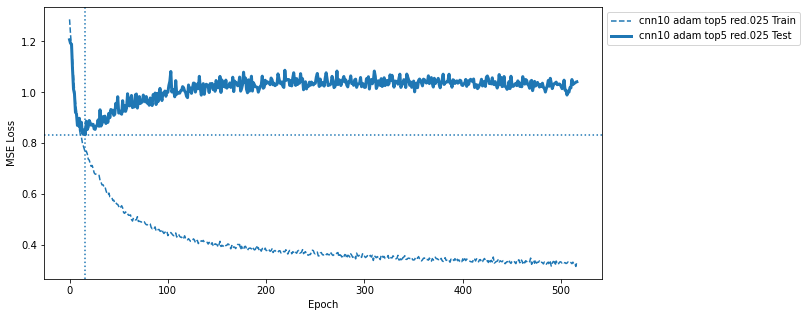

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn10 adam top5 red.025
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn10 adam top5 red.025
test split
Running cnn10 adam top5 red.025


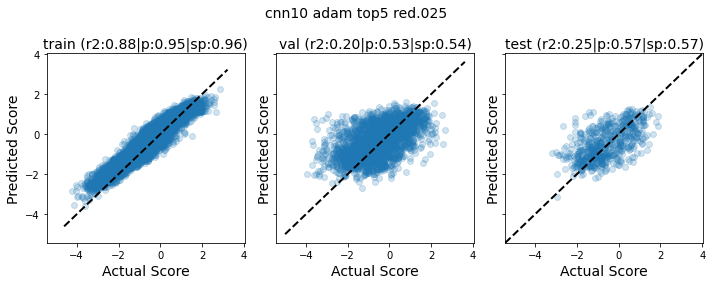

In [170]:
r = 0.025
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r)

split_sizes[r] = {}
for split in red_split_dfs:
    split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')


cnn10_name = 'cnn10 adam top5 red.025'
model_res[cnn10_name] = collect_model_stats(
    cnn10_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn10_name] = parity_pred_by_split(cnn10_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

train reduced (1860, 12)
val reduced (465, 12)
test reduced (122, 11)


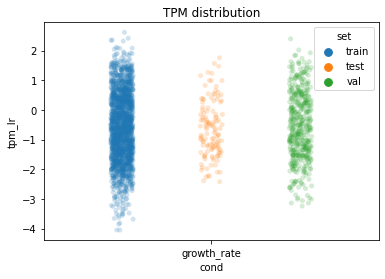

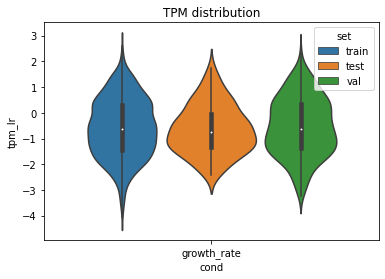

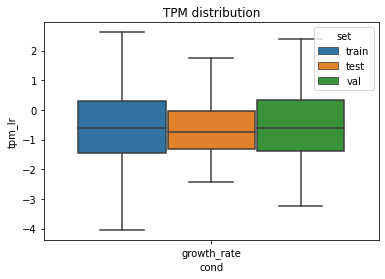

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


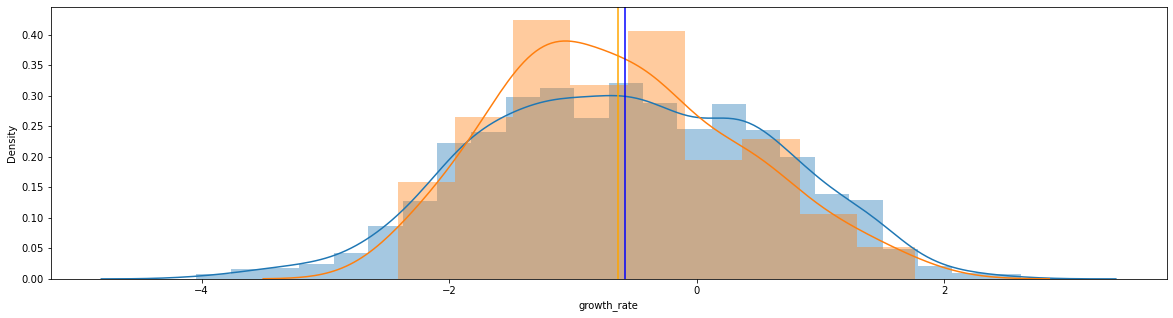


0.005:{'train': 1860, 'val': 465, 'test': 122}


E:144 | train loss:0.223 | val loss: 1.356:   3%|▎         | 144/5000 [00:09<05:10, 15.63it/s]

EarlyStopping counter: 125 out of 500


E:269 | train loss:0.164 | val loss: 1.340:   5%|▌         | 270/5000 [00:17<05:02, 15.63it/s]

EarlyStopping counter: 250 out of 500


E:394 | train loss:0.124 | val loss: 1.271:   8%|▊         | 394/5000 [00:25<04:54, 15.64it/s]

EarlyStopping counter: 375 out of 500


E:516 | train loss:0.110 | val loss: 1.258:  10%|█         | 516/5000 [00:33<04:47, 15.57it/s]


EarlyStopping counter: 500 out of 500
Early stopping


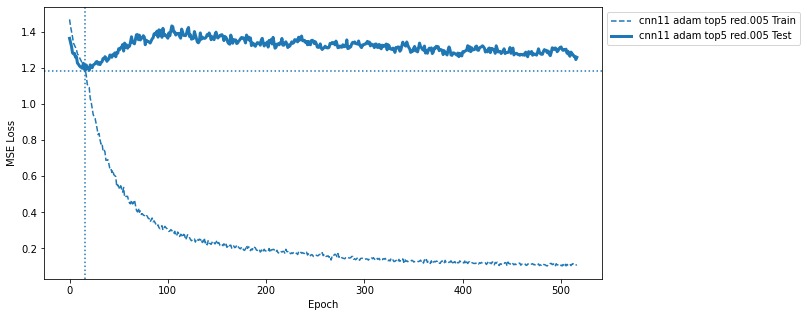

train split
Running cnn11 adam top5 red.005
val split
Running cnn11 adam top5 red.005
test split
Running cnn11 adam top5 red.005


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

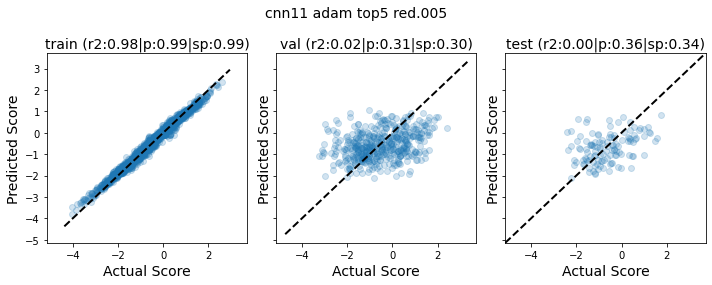

In [171]:
r = 0.005
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r)

split_sizes[r] = {}
for split in red_split_dfs:
    split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')


cnn11_name = 'cnn11 adam top5 red.005'
model_res[cnn11_name] = collect_model_stats(
    cnn11_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

pred_dfs[cnn11_name] = parity_pred_by_split(cnn11_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

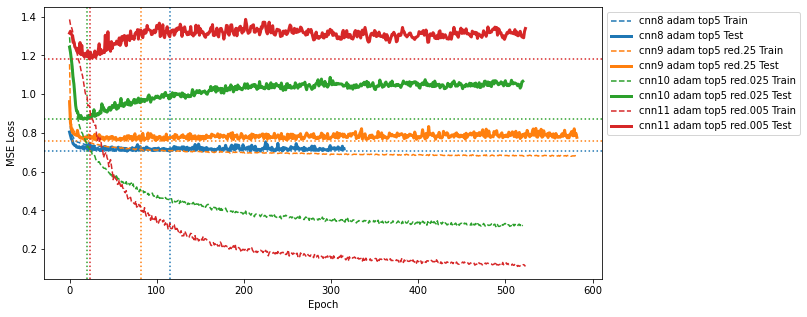

In [149]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res][1:])


1.0:{'train': 371904, 'val': 92977, 'test': 24467}
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


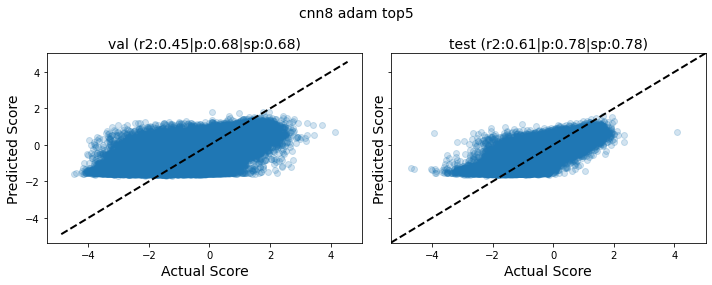

In [179]:
# put non reduced model in pred_dfs

non_red_split_dfs = {
    'train':train_df,
    'val':val_df,
    'test':test_df.reset_index(),   
}

r=1.0
split_sizes[r] = {}
for split in non_red_split_dfs:
    split_sizes[r][split] = non_red_split_dfs[split].shape[0]
print(f'\n{r}:{split_sizes[r]}')


pred_dfs[cnn8_name] = parity_pred_by_split(cnn8_name,
                                DEVICE,
                                non_red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

In [180]:
# reduced models
ms = [cnn8_name,cnn9_name,cnn10_name,cnn11_name]
ms

['cnn8 adam top5',
 'cnn9 adam top5 red.25',
 'cnn10 adam top5 red.025',
 'cnn11 adam top5 red.005']

In [181]:
mod2red = {
    cnn8_name:1.0,
    cnn9_name:0.25,
    cnn10_name:0.025,
    cnn11_name:0.005
}

In [182]:
reduction_data = []
for mod in ms:
    # get the test set prediction score
    test_pred_df = pred_dfs[mod]['test']
    ytrue = test_pred_df['truth'].values
    ypred = test_pred_df['pred'].values
    r2 = r2_score(ytrue,ypred)
    
    # get reduction percent
    red = mod2red[mod]
    
    # get train set size
    train_size = split_sizes[red]['train']
    
    reduction_data.append([mod,red,r2,train_size])

red_res_df = pd.DataFrame(reduction_data, columns = ['model_name','reduction','r2','train_size'])
    

In [187]:
red_res_df

model_name  reduction        r2  train_size
0           cnn8 adam top5      1.000  0.607797      371904
1    cnn9 adam top5 red.25      0.250  0.548384       92976
2  cnn10 adam top5 red.025      0.025  0.252590        9298
3  cnn11 adam top5 red.005      0.005  0.000212        1860

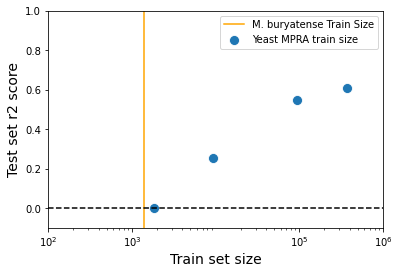

In [215]:
sns.scatterplot(data=red_res_df, x='train_size', y='r2',s=100,label="Yeast MPRA train size")
plt.xscale('log')
plt.ylim(-0.1,1)
#plt.xlim(-100,1000000)
plt.xticks([100,1000,100000,1000000])
plt.axvline(1414,c='orange',label='M. buryatense Train Size')
plt.axhline(0,c='black',linestyle='--')
plt.xlabel("Train set size",fontsize=14)
plt.ylabel("Test set r2 score",fontsize=14)
plt.legend()
plt.show()

# Shuffled versions of reduced

In [216]:
seq_col_name = 'shuffled_seq'
target_col_name = 'growth_rate'

# Dfs for the full train/test split
final_dls_shuff = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name
)

# Dfs from further spliting train into train and val
dls_shuff = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

shuff_ohe_train_dl,shuff_ohe_val_dl = dls_shuff['ohe']

In [225]:
full_split_dfs = {
    #'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df.reset_index(),   
}

In [234]:
shuff_pred_dfs = {}
shuff_split_sizes = {}


1.0:{'train': 371904, 'val': 92977, 'test': 24467}


E:53 | train loss:1.204 | val loss: 1.223:   3%|▎         | 54/2000 [11:15<6:45:19, 12.50s/it]

EarlyStopping counter: 50 out of 200


E:103 | train loss:1.192 | val loss: 1.234:   5%|▌         | 104/2000 [21:40<6:35:10, 12.51s/it]

EarlyStopping counter: 100 out of 200


E:153 | train loss:1.188 | val loss: 1.233:   8%|▊         | 154/2000 [32:05<6:24:05, 12.48s/it]

EarlyStopping counter: 150 out of 200


E:203 | train loss:1.186 | val loss: 1.241:  10%|█         | 203/2000 [42:30<6:16:17, 12.56s/it]

EarlyStopping counter: 200 out of 200
Early stopping


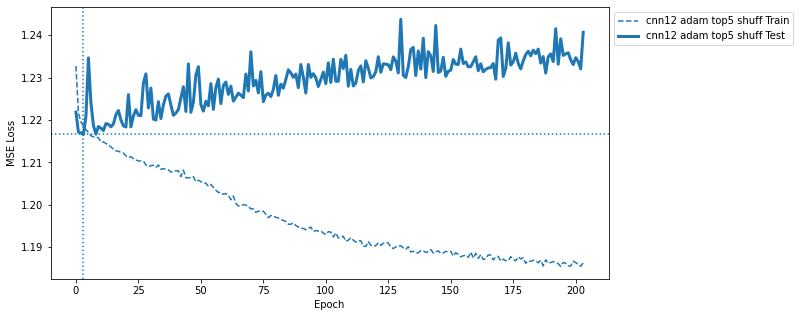

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn12 adam top5 shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn12 adam top5 shuff


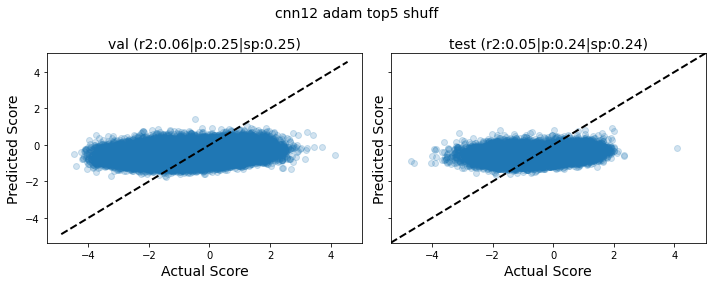

In [239]:
cnn12_name = 'cnn12 adam top5 shuff'

r=1.0
shuff_split_sizes[r] = {}
for split in full_split_dfs:
    shuff_split_sizes[r][split] = full_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

model_res[cnn12_name] = collect_model_stats(
    cnn12_name,
    seq_len,
    'ohe',
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn12_name] = parity_pred_by_split(cnn12_name,
                                DEVICE,
                                full_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

train reduced (92976, 12)
val reduced (23244, 12)
test reduced (6117, 11)


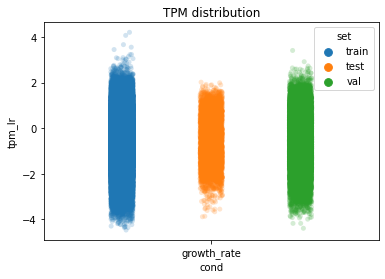

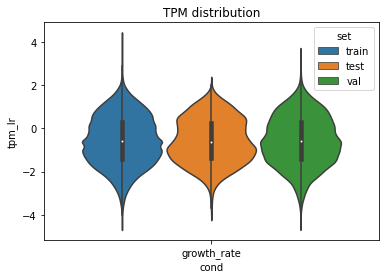

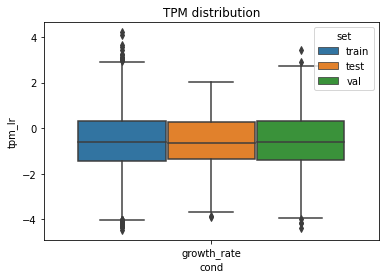

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


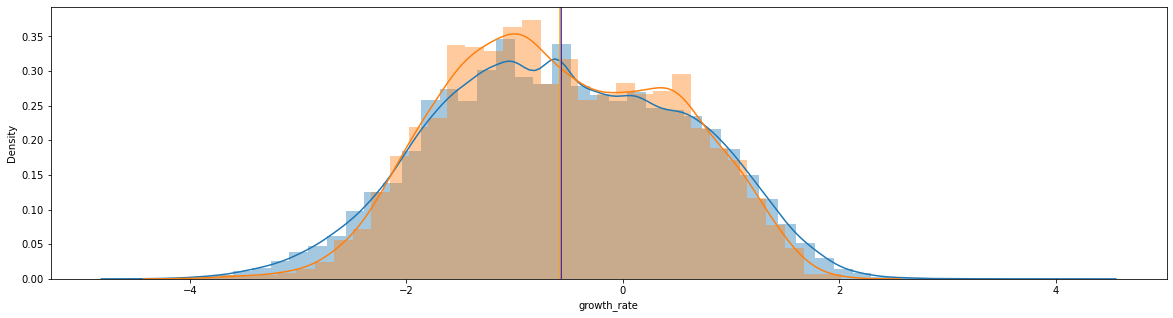


0.25:{'train': 92976, 'val': 23244, 'test': 6117}


E:57 | train loss:1.144 | val loss: 1.233:   3%|▎         | 58/2000 [03:02<1:41:54,  3.15s/it]

EarlyStopping counter: 50 out of 200


E:107 | train loss:1.120 | val loss: 1.246:   5%|▌         | 108/2000 [05:38<1:38:25,  3.12s/it]

EarlyStopping counter: 100 out of 200


E:157 | train loss:1.099 | val loss: 1.255:   8%|▊         | 158/2000 [08:14<1:35:49,  3.12s/it]

EarlyStopping counter: 150 out of 200


E:207 | train loss:1.093 | val loss: 1.258:  10%|█         | 207/2000 [10:51<1:34:02,  3.15s/it]

EarlyStopping counter: 200 out of 200
Early stopping


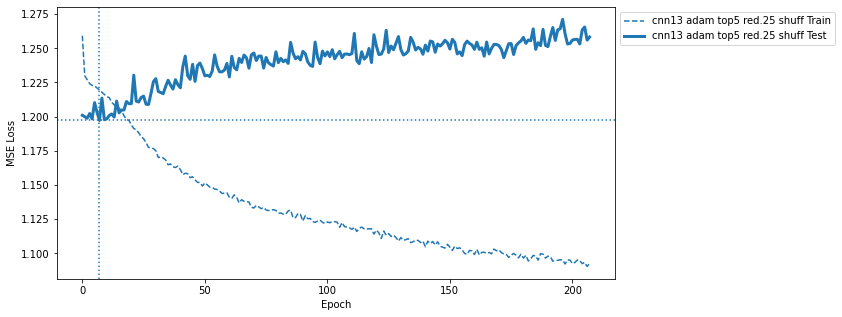

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn13 adam top5 red.25 shuff
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn13 adam top5 red.25 shuff
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn13 adam top5 red.25 shuff


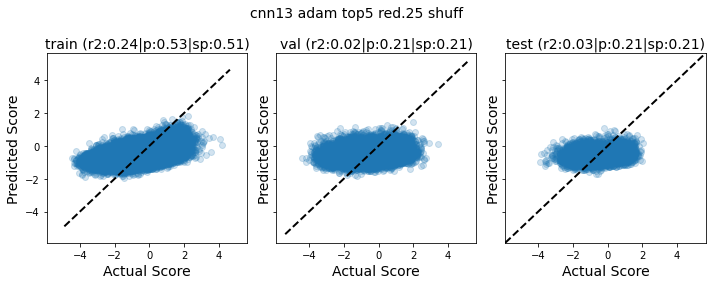

In [240]:
r = 0.25
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,seq_col_name,target_col_name)

shuff_split_sizes[r] = {}
for split in red_split_dfs:
    shuff_split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

cnn13_name = 'cnn13 adam top5 red.25 shuff'
model_res[cnn13_name] = collect_model_stats(
    cnn13_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn13_name] = parity_pred_by_split(cnn13_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )


train reduced (9298, 12)
val reduced (2324, 12)
test reduced (612, 11)


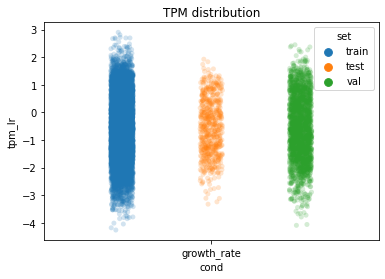

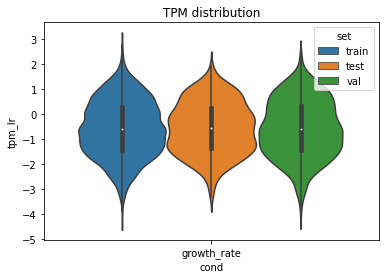

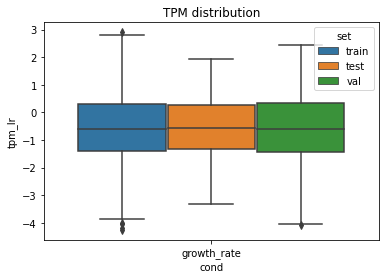

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


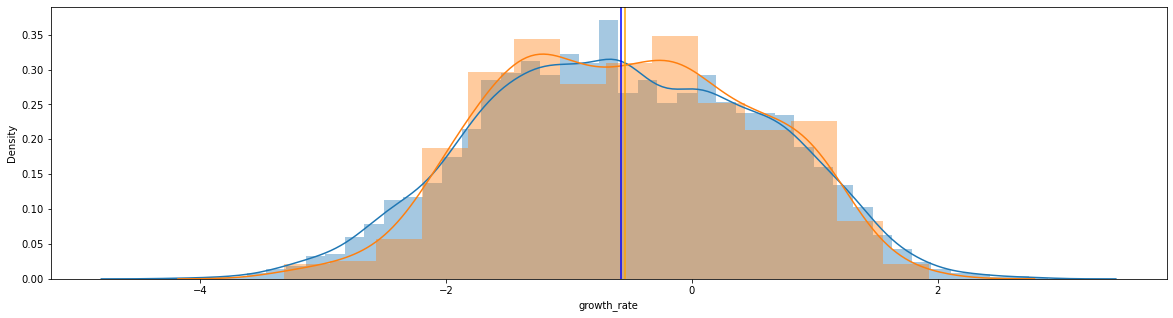


0.025:{'train': 9298, 'val': 2324, 'test': 612}


E:59 | train loss:0.880 | val loss: 1.406:   3%|▎         | 60/2000 [00:18<10:00,  3.23it/s]

EarlyStopping counter: 50 out of 200


E:109 | train loss:0.699 | val loss: 1.516:   6%|▌         | 110/2000 [00:34<09:46,  3.22it/s]

EarlyStopping counter: 100 out of 200


E:159 | train loss:0.630 | val loss: 1.565:   8%|▊         | 160/2000 [00:49<09:32,  3.22it/s]

EarlyStopping counter: 150 out of 200


E:209 | train loss:0.571 | val loss: 1.559:  10%|█         | 209/2000 [01:05<09:19,  3.20it/s]

EarlyStopping counter: 200 out of 200
Early stopping


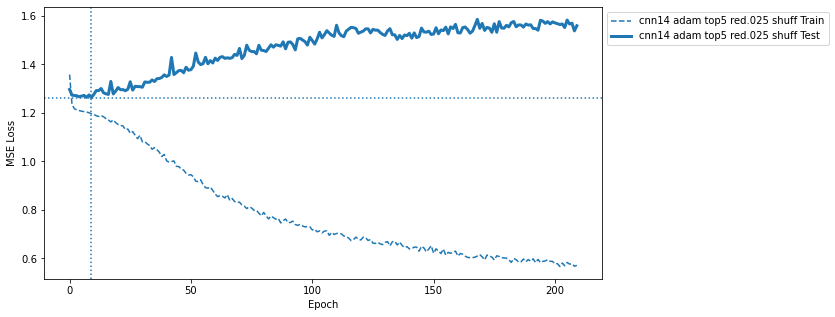

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn14 adam top5 red.025 shuff
val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn14 adam top5 red.025 shuff
test split
Running cnn14 adam top5 red.025 shuff


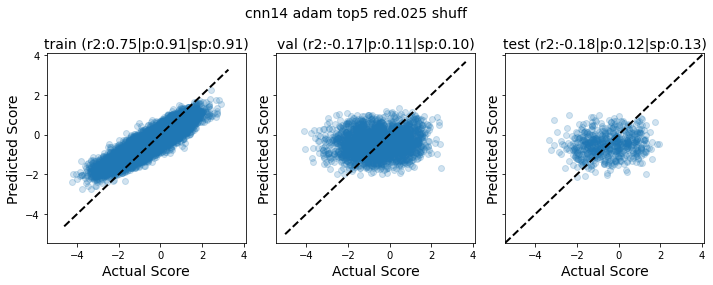

In [241]:
r = 0.025
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,seq_col_name,target_col_name)

shuff_split_sizes[r] = {}
for split in red_split_dfs:
    shuff_split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

cnn14_name = 'cnn14 adam top5 red.025 shuff'
model_res[cnn14_name] = collect_model_stats(
    cnn14_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn14_name] = parity_pred_by_split(cnn14_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

train reduced (1860, 12)
val reduced (465, 12)
test reduced (122, 11)


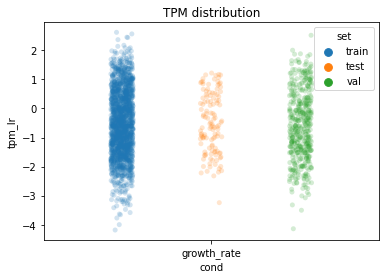

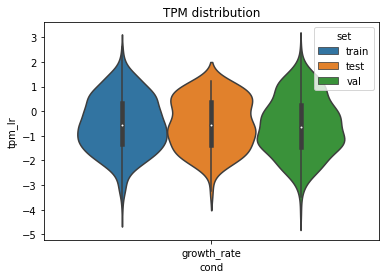

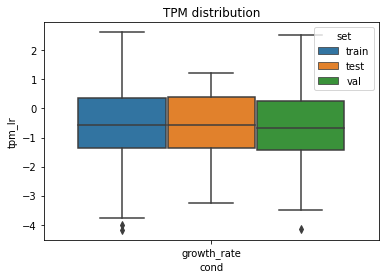

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


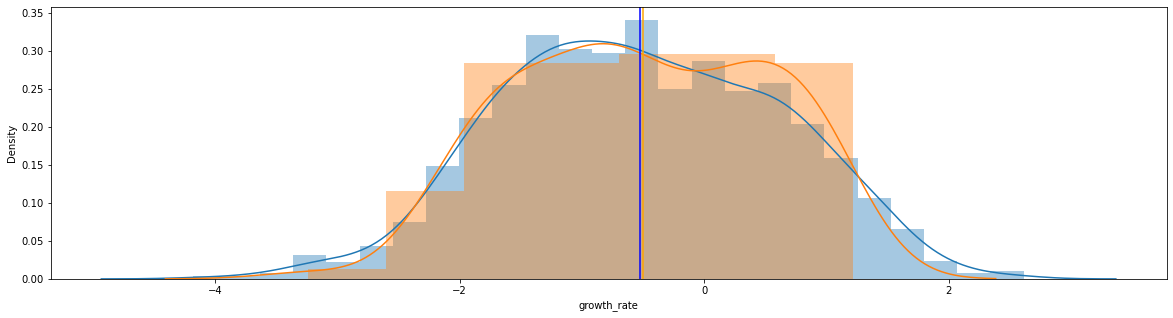


0.005:{'train': 1860, 'val': 465, 'test': 122}


E:65 | train loss:0.609 | val loss: 1.534:   3%|▎         | 66/2000 [00:04<02:03, 15.60it/s]

EarlyStopping counter: 50 out of 200


E:115 | train loss:0.378 | val loss: 1.576:   6%|▌         | 116/2000 [00:07<02:01, 15.51it/s]

EarlyStopping counter: 100 out of 200


E:165 | train loss:0.298 | val loss: 1.556:   8%|▊         | 166/2000 [00:10<01:57, 15.62it/s]

EarlyStopping counter: 150 out of 200


E:212 | train loss:0.262 | val loss: 1.556:  11%|█         | 212/2000 [00:13<01:55, 15.50it/s]


EarlyStopping counter: 200 out of 200
Early stopping


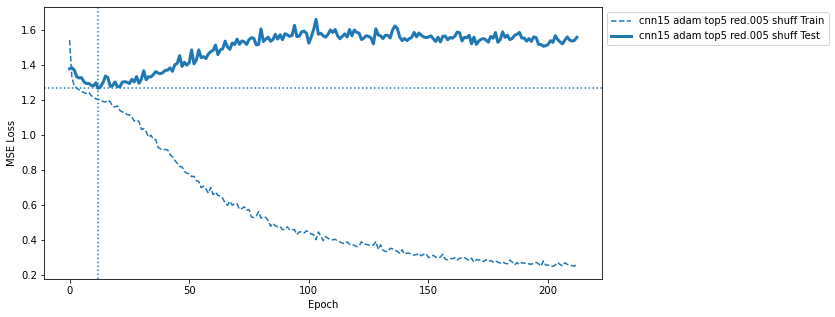

train split
Running cnn15 adam top5 red.005 shuff
val split
Running cnn15 adam top5 red.005 shuff
test split
Running cnn15 adam top5 red.005 shuff


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

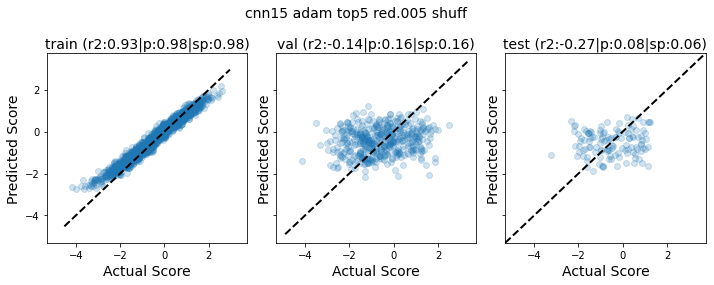

In [242]:
r = 0.005
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,seq_col_name,target_col_name)

shuff_split_sizes[r] = {}
for split in red_split_dfs:
    shuff_split_sizes[r][split] = red_split_dfs[split].shape[0]
print(f'\n{r}:{shuff_split_sizes[r]}')

cnn15_name = 'cnn15 adam top5 red.005 shuff'
model_res[cnn15_name] = collect_model_stats(
    cnn15_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam
)

shuff_pred_dfs[cnn15_name] = parity_pred_by_split(cnn15_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['train','val','test']
                    )

In [243]:
# reduced shuffled models
ms_shuff = [cnn12_name,cnn13_name,cnn14_name,cnn15_name]

mod2red_shuff = {
    cnn12_name:1.0,
    cnn13_name:0.25,
    cnn14_name:0.025,
    cnn15_name:0.005
}

shuff_reduction_data = []
for mod in ms_shuff:
    # get the test set prediction score
    test_pred_df = shuff_pred_dfs[mod]['test']
    ytrue = test_pred_df['truth'].values
    ypred = test_pred_df['pred'].values
    r2 = r2_score(ytrue,ypred)
    
    # get reduction percent
    red = mod2red_shuff[mod]
    
    # get train set size
    train_size = shuff_split_sizes[red]['train']
    
    shuff_reduction_data.append([mod,red,r2,train_size])

shuff_red_res_df = pd.DataFrame(shuff_reduction_data, columns = ['model_name','reduction','r2','train_size'])
shuff_red_res_df  

model_name  reduction        r2  train_size
0          cnn12 adam top5 shuff      1.000  0.054940      371904
1   cnn13 adam top5 red.25 shuff      0.250  0.025253       92976
2  cnn14 adam top5 red.025 shuff      0.025 -0.178670        9298
3  cnn15 adam top5 red.005 shuff      0.005 -0.268669        1860

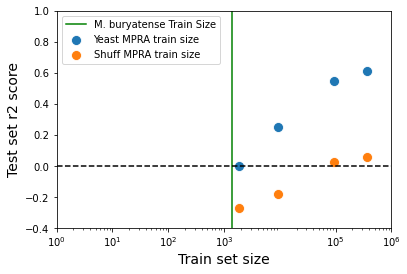

In [248]:
sns.scatterplot(data=red_res_df, x='train_size', y='r2',s=100,label="Yeast MPRA train size")
sns.scatterplot(data=shuff_red_res_df, x='train_size', y='r2',s=100,label="Shuff MPRA train size")
plt.xscale('log')
plt.ylim(-0.4,1)
#plt.xlim(-100,1000000)
plt.xticks([1,10,100,1000,100000,1000000])
plt.axvline(1414,c='green',label='M. buryatense Train Size')
plt.axhline(0,c='black',linestyle='--')
plt.xlabel("Train set size",fontsize=14)
plt.ylabel("Test set r2 score",fontsize=14)
plt.legend()
plt.show()

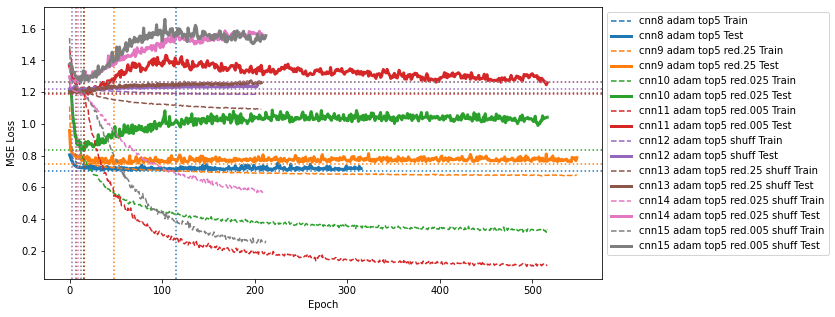

In [249]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res][1:])

# View filters

In [263]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    #print(model_weights[0].shape)
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    seq_len = model_weights.shape[-1]
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(seq_len))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

In [264]:
def view_conv_filters_for_cnn(cnn,seqs):
    conv_layers, model_weights, bias_weights = get_conv_layers_from_model(cnn)
    #view_filters(model_weights)
    filter_activations = get_filter_activations(seqs, conv_layers[0])
    view_filters_and_logos(model_weights,filter_activations)

In [265]:
cnn_model = model_res[cnn8_name]['model']
cnn_model

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=1152, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)

Total convolutional layers: 2
Num filters 32
filt_width 8
torch.Size([32, 4, 8])


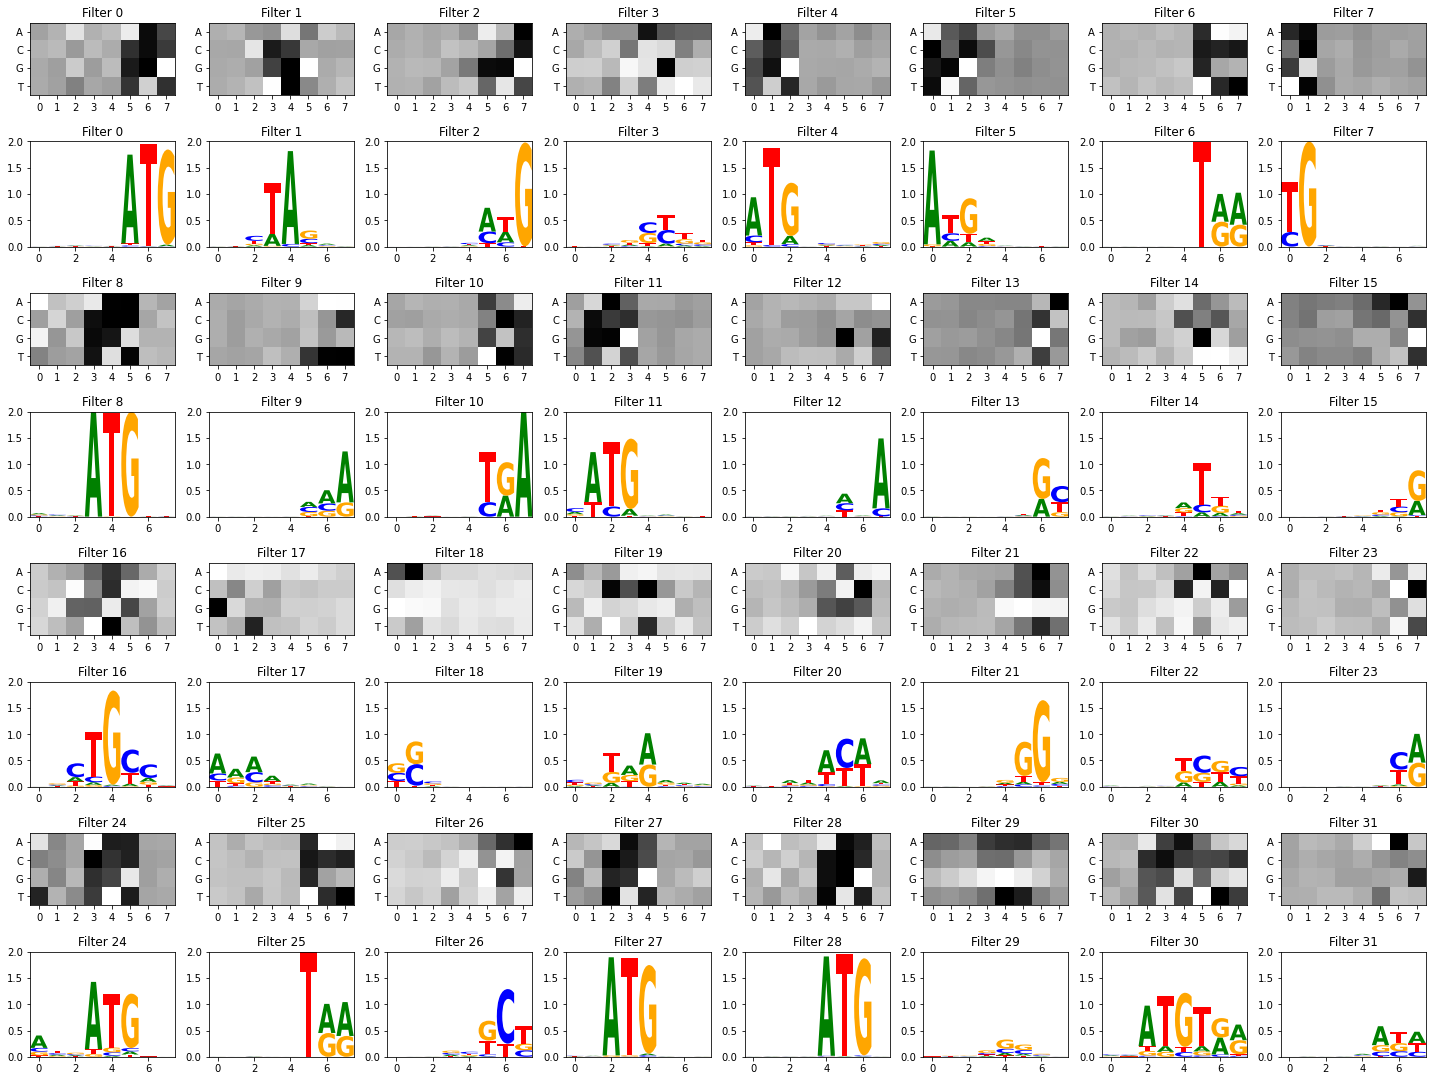

In [267]:
# all prom seq examples: just using to get activations of filters, not train or test
all_seqs = test_df['UTR'].values

view_conv_filters_for_cnn(cnn_model,all_seqs)

# Save some models

In [269]:
path = 'model_out/yeast_MPRA_full_model.pth'
torch.save(cnn_model, path)

In [ ]:
# Model class must be defined somewhere
# model = torch.load(PATH)
# model.eval()

# LSTM stuff

train reduced (9298, 12)
val reduced (2324, 12)
test reduced (612, 11)


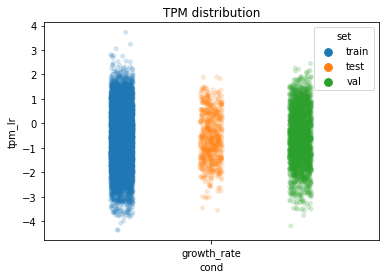

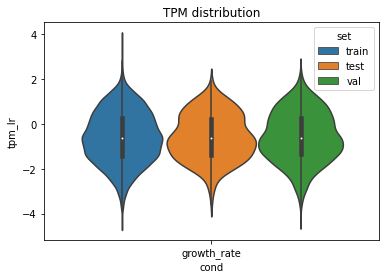

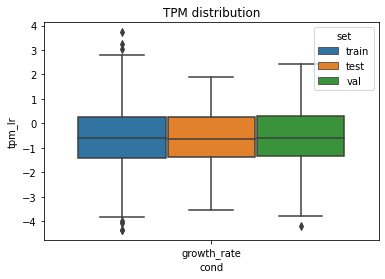

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


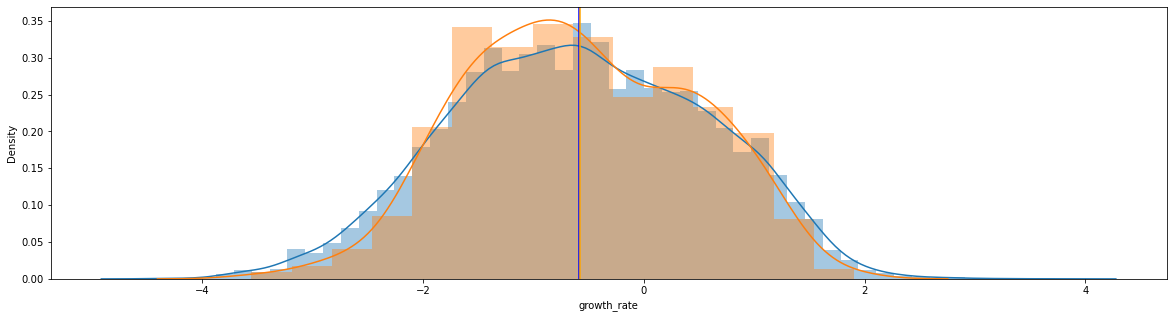

In [20]:
# quickly Try CNNLSTM model
r = 0.025
red_ohe_train_dl, red_ohe_val_dl, red_split_dfs = reduction_loop(r,"UTR","growth_rate")

# split_sizes[r] = {}
# for split in red_split_dfs:
#     split_sizes[r][split] = red_split_dfs[split].shape[0]
# print(f'\n{r}:{split_sizes[r]}')

E:79 | train loss:0.569 | val loss: 1.116:   4%|▍         | 80/2000 [01:11<28:15,  1.13it/s]

EarlyStopping counter: 50 out of 200


E:129 | train loss:0.194 | val loss: 1.430:   6%|▋         | 130/2000 [01:55<27:35,  1.13it/s]

EarlyStopping counter: 100 out of 200


E:179 | train loss:0.107 | val loss: 1.358:   9%|▉         | 180/2000 [02:39<26:49,  1.13it/s]

EarlyStopping counter: 150 out of 200


E:229 | train loss:0.094 | val loss: 1.371:  11%|█▏        | 229/2000 [03:23<26:17,  1.12it/s]

EarlyStopping counter: 200 out of 200
Early stopping


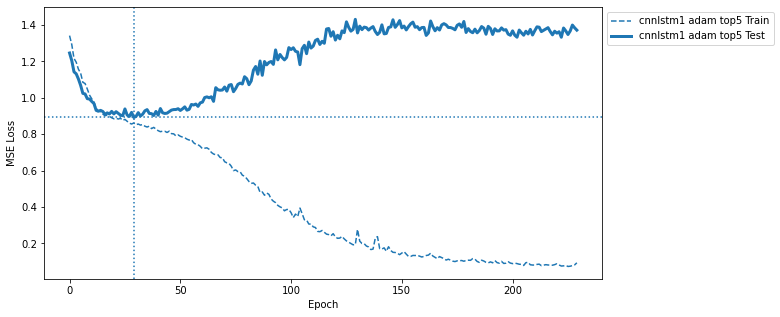

val split
Running cnnlstm1 adam top5
test split
Running cnnlstm1 adam top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

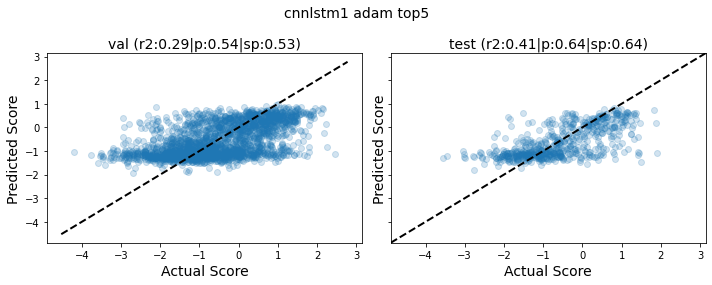

In [21]:
lstm1_name = 'cnnlstm1 adam top5'
model = m.DNA_CNNLSTM(
    seq_len,
    DEVICE,
    num_classes=1
)

model_res[lstm1_name] = collect_model_stats(
    lstm1_name,
    seq_len,
    'ohe',
    red_ohe_train_dl,
    red_ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

pred_dfs[lstm1_name] = parity_pred_by_split(lstm1_name,
                                DEVICE,
                                red_split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

In [36]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 device,
                 num_filters=32,
                 kernel_size=6,
                 hidden_dim=50,
                 num_layers=2,
                 fc_node_num1=100,
                 dropout=0.2,
                 bidir=True,
                 num_classes=3):
        super().__init__()
        self.seq_len = seq_len
        self.device = device
        self.num_filters = num_filters
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.num_layers=num_layers
        self.bidir=bidir
        self.D = num_layers*2 if bidir else num_layers # hidden state calc
        self.linear_input_dim = 2*hidden_dim if bidir else hidden_dim
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.rnn = nn.LSTM(
            self.num_filters, 
            self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidir,
            dropout=self.dropout
        )
        self.fc = nn.Sequential(
            #nn.Linear(hidden_dim, fc_node_num1), # *2 for bidir?
            nn.Linear(self.linear_input_dim, fc_node_num1), # *2 for bidir?
            nn.ReLU(),
            nn.Linear(fc_node_num1, num_classes)
        )
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(self.D, batch_size, self.hidden_dim).to(self.device), 
                        torch.zeros(self.D, batch_size, self.hidden_dim).to(self.device))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # this gets H and C
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?

        out = self.fc(last_layer) 
        if verbose:
            print("last layer:", last_layer.shape)
            print("LSTM->FC out shape:",out.shape)        
        
        return out

E:74 | train loss:0.622 | val loss: 0.702:   4%|▍         | 75/2000 [43:52<18:53:52, 35.34s/it]

EarlyStopping counter: 50 out of 200


E:124 | train loss:0.617 | val loss: 0.715:   6%|▋         | 125/2000 [1:13:28<18:31:15, 35.56s/it]

EarlyStopping counter: 100 out of 200


E:174 | train loss:0.599 | val loss: 0.719:   9%|▉         | 175/2000 [1:42:55<17:46:28, 35.06s/it]

EarlyStopping counter: 150 out of 200


E:224 | train loss:0.590 | val loss: 0.729:  11%|█         | 224/2000 [2:12:09<17:27:45, 35.40s/it]

EarlyStopping counter: 200 out of 200
Early stopping


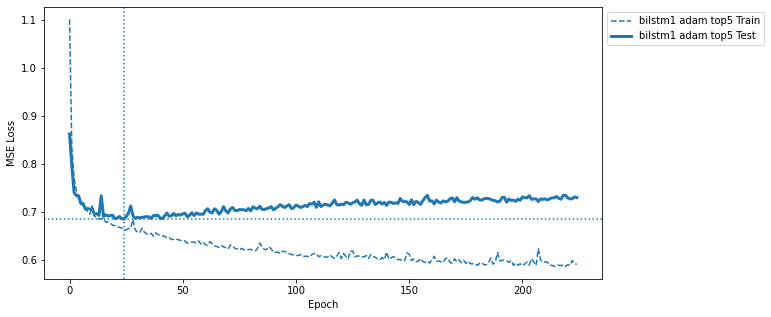

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running bilstm1 adam top5
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyError: 'index'

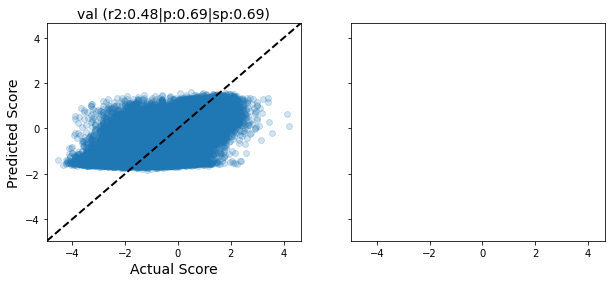

In [23]:
lstm1_name = 'bilstm1 adam top5'
model = DNA_biLSTM(
    seq_len,
    DEVICE,
    num_classes=1
)

model_res[lstm1_name] = collect_model_stats(
    lstm1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model,
    load_best=True,
    verbose=True
)

pred_dfs[lstm1_name] = parity_pred_by_split(lstm1_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )

test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running bilstm1 adam top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running bilstm1 adam top5


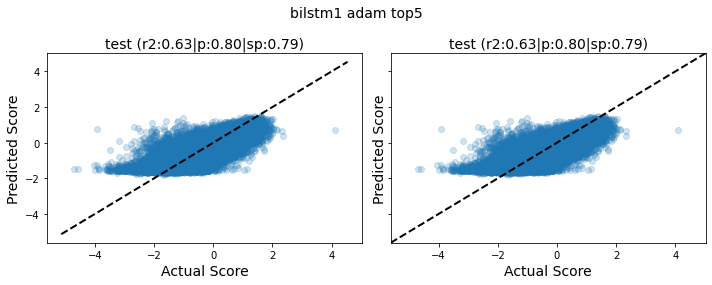

In [36]:
pred_dfs[lstm1_name] = parity_pred_by_split(lstm1_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['test','test']
                    )

E:165 | train loss:0.641 | val loss: 0.707:   8%|▊         | 166/2000 [35:48<6:35:38, 12.94s/it]

EarlyStopping counter: 50 out of 200


E:215 | train loss:0.620 | val loss: 0.719:  11%|█         | 216/2000 [46:37<6:25:27, 12.96s/it]

EarlyStopping counter: 100 out of 200


E:265 | train loss:0.598 | val loss: 0.738:  13%|█▎        | 266/2000 [57:25<6:14:12, 12.95s/it]

EarlyStopping counter: 150 out of 200


E:315 | train loss:0.580 | val loss: 0.757:  16%|█▌        | 315/2000 [1:08:12<6:04:50, 12.99s/it]

EarlyStopping counter: 200 out of 200
Early stopping


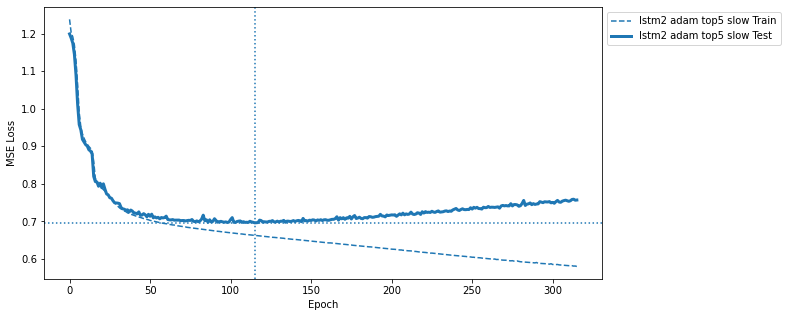

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running lstm2 adam top5 slow


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running lstm2 adam top5 slow


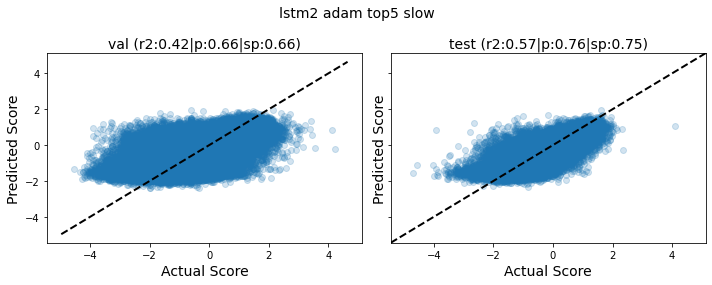

In [27]:
lstm2_name = 'lstm2 adam top5 slow'
model = m.DNA_LSTM(
    seq_len,
    DEVICE,
    num_classes=1
)

model_res[lstm2_name] = collect_model_stats(
    lstm2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs[lstm2_name] = parity_pred_by_split(lstm2_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test'])
                                            
                                            

E:93 | train loss:0.653 | val loss: 0.711:   5%|▍         | 94/2000 [20:11<6:46:41, 12.80s/it]

EarlyStopping counter: 50 out of 200


E:143 | train loss:0.646 | val loss: 0.721:   7%|▋         | 144/2000 [30:55<6:41:01, 12.96s/it]

EarlyStopping counter: 100 out of 200


E:193 | train loss:0.641 | val loss: 0.725:  10%|▉         | 194/2000 [41:43<6:29:35, 12.94s/it]

EarlyStopping counter: 150 out of 200


E:243 | train loss:0.639 | val loss: 0.726:  12%|█▏        | 243/2000 [52:30<6:19:38, 12.96s/it]

EarlyStopping counter: 200 out of 200
Early stopping


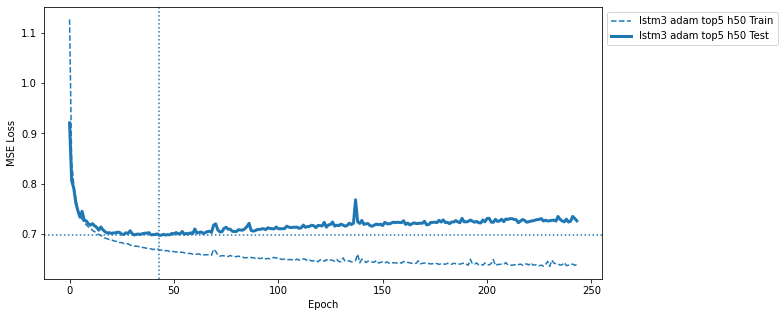

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running lstm3 adam top5 h50


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running lstm3 adam top5 h50


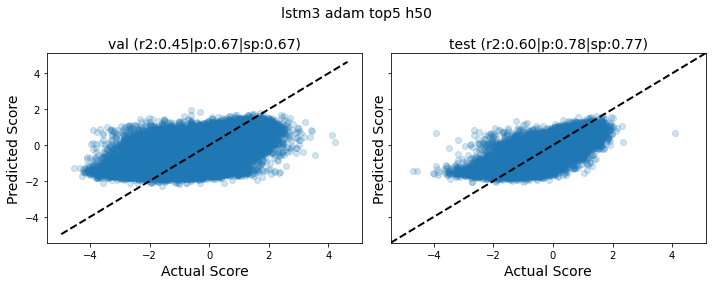

In [28]:
lstm3_name = 'lstm3 adam top5 h50'
model = m.DNA_LSTM(
    seq_len,
    DEVICE,
    hidden_dim=50,
    num_classes=1
)

model_res[lstm3_name] = collect_model_stats(
    lstm3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs[lstm3_name] = parity_pred_by_split(lstm3_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test'])


E:64 | train loss:0.566 | val loss: 0.763:   3%|▎         | 65/2000 [15:12<7:35:07, 14.11s/it]

EarlyStopping counter: 50 out of 200


E:114 | train loss:0.551 | val loss: 0.772:   6%|▌         | 115/2000 [26:58<7:23:59, 14.13s/it]

EarlyStopping counter: 100 out of 200


E:164 | train loss:0.563 | val loss: 0.781:   8%|▊         | 165/2000 [38:45<7:11:13, 14.10s/it]

EarlyStopping counter: 150 out of 200


E:214 | train loss:0.562 | val loss: 0.778:  11%|█         | 214/2000 [50:31<7:01:37, 14.16s/it]

EarlyStopping counter: 200 out of 200
Early stopping


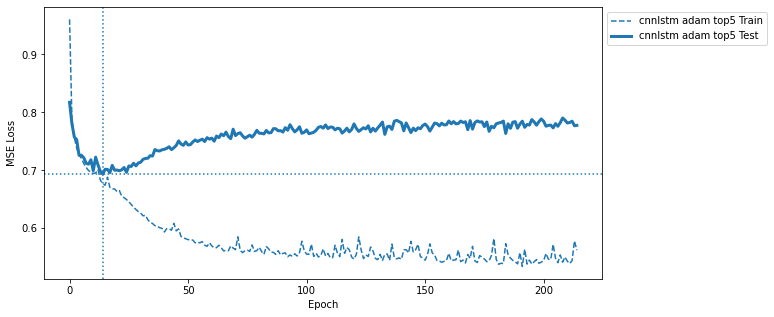

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnnlstm adam top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnnlstm adam top5


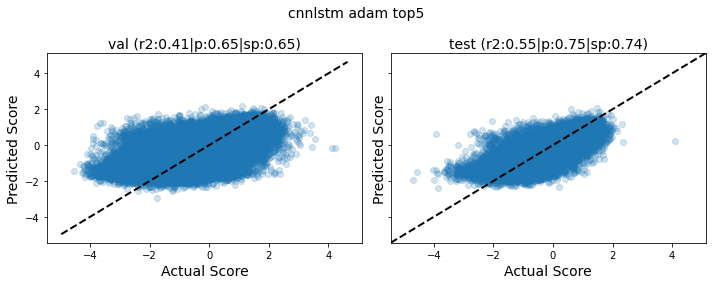

In [29]:
cnnlstm_name = 'cnnlstm adam top5'
model = m.DNA_CNNLSTM(
    seq_len,
    DEVICE,
    num_classes=1
)

model_res[cnnlstm_name] = collect_model_stats(
    cnnlstm_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs[cnnlstm_name] = parity_pred_by_split(cnnlstm_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test'])

E:263 | train loss:0.657 | val loss: 0.694:  13%|█▎        | 264/2000 [1:02:10<6:42:52, 13.92s/it]

EarlyStopping counter: 50 out of 200


E:313 | train loss:0.651 | val loss: 0.696:  16%|█▌        | 314/2000 [1:13:52<6:35:35, 14.08s/it]

EarlyStopping counter: 100 out of 200


E:363 | train loss:0.649 | val loss: 0.697:  18%|█▊        | 364/2000 [1:25:37<6:24:56, 14.12s/it]

EarlyStopping counter: 150 out of 200


E:413 | train loss:0.640 | val loss: 0.707:  21%|██        | 413/2000 [1:37:22<6:14:11, 14.15s/it]

EarlyStopping counter: 200 out of 200
Early stopping


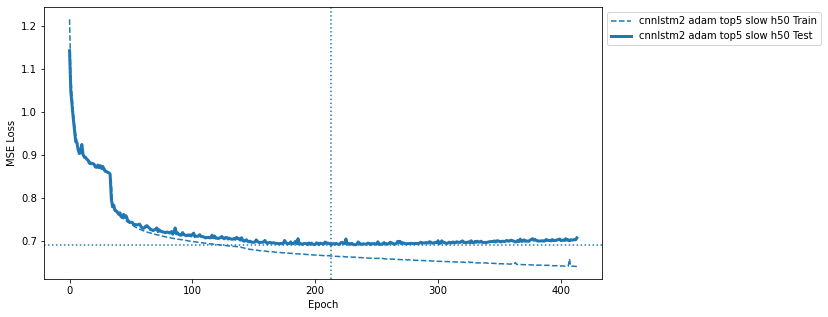

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnnlstm2 adam top5 slow h50


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnnlstm2 adam top5 slow h50


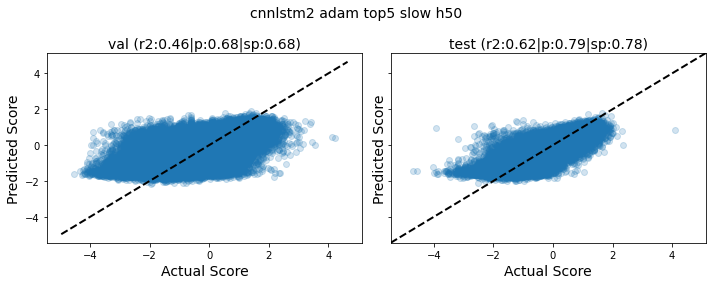

In [30]:
cnnlstm2_name = 'cnnlstm2 adam top5 slow h50'
model = m.DNA_CNNLSTM(
    seq_len,
    DEVICE,
    hidden_dim=50,
    num_classes=1
)

model_res[cnnlstm2_name] = collect_model_stats(
    cnnlstm2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs[cnnlstm2_name] = parity_pred_by_split(cnnlstm2_name,
                                DEVICE,
                                split_dfs,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test'])

In [45]:
model_res[cnnlstm2_name].keys()

dict_keys(['model_name', 'model', 'train_losses', 'val_losses', 'epoch_stop', 'best_val_score', 'data_label'])

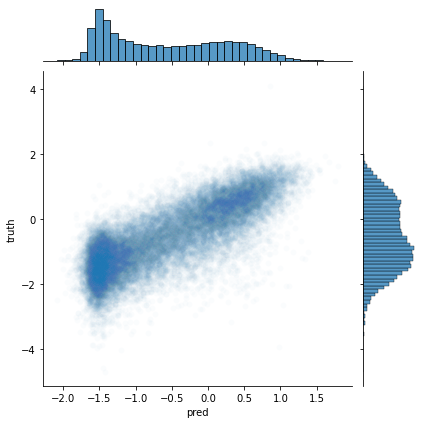

In [31]:
sns.jointplot(data = pred_dfs[cnnlstm2_name]['test'], x='pred',y='truth',alpha=0.02)


In [33]:
pred_dfs[cnnlstm2_name].keys()

dict_keys(['val', 'test'])

In [50]:
d1 = pd.DataFrame()
d2 = pd.DataFrame([[1,2,3,4],[1,2,3,4],[1,2,3,4]],columns=['a','b','c','d'])

d22 = pd.concat([d1,d2])


In [51]:
d3 = pd.DataFrame([[4,5,6,7],[6,5,4,3],[6,7,8,9]],columns=['a','b','c','d'])

In [54]:
pd.concat([d22,d3])

a  b  c  d
0  1  2  3  4
1  1  2  3  4
2  1  2  3  4
0  4  5  6  7
1  6  5  4  3
2  6  7  8  9

val split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn8 adam top5


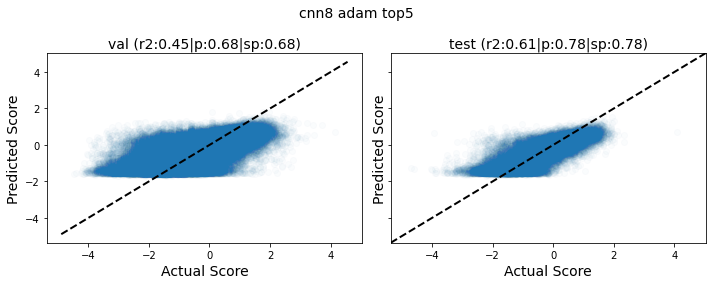

In [49]:
pred_dfs = parity_pred_by_split(cnn8_name,
                                DEVICE,
                                locus_col='index',
                                seq_col=seq_col_name,
                                target_col=target_col_name,
                                splits=['val','test']
                    )